Content:

1.   Get data
2.   Get required libraries
3.   Function for fetching and formatting data
4.   Function for evaluating model and performance
5.   5 different model architectures for training
6.   Training and evaluating window size 11
7.   Training and evaluating window size 13
8.   Training and evaluating window size 15
9.   Training and evaluating window size 17
10.  Secondary Structure Predictor


Note: For just using the Secondary Structure Predictor - run 1-3 and then run code in 10.

Note: Some functions are taken or adapted from the colab notebooks provided by the course instructors.


# 1. Get the data in this session

In [30]:
# get training, crossvalidation and blind test data
!git clone https://github.com/katarinaelez/protein-ss-pred.git

fatal: destination path 'protein-ss-pred' already exists and is not an empty directory.


In [31]:
# get models and weights for the highest scoring prediction model
!git clone https://github.com/Dariolino/secondary_structure_prediction_project.git

fatal: destination path 'secondary_structure_prediction_project' already exists and is not an empty directory.


# 2. Get required libraries

In [34]:
import numpy as np

import keras
from keras import layers
from keras import regularizers
from keras.models import model_from_json

import json #for accessing prestored model architecture
import pickle #for accessing prestored model weights


import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

# 3. Declare functions to fetch and format data

In [35]:
def parse_pssm(pssm_filename):
    """Extract protein sequence and MSA frequency profile from PSSM file

    Parameters:
    pssm_filename (str): filepath to PSSM

    Returns:
    encoding (numpy array): one-hot encoded protein sequence
    profile (list): binary profile of input sequence
    """
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    num_aas = len(amino_acids)
    sequence = ''
    profile = []

    # fetch protein sequence and frequencies from pssm file
    with open(pssm_filename) as pssm:
        pssm_lines = pssm.readlines()
        for line in pssm_lines[3:-6]:
            profile_line = []
            for n in line.rstrip().split()[22:-2]:
                profile_line.append(float(n)/100)
            profile.append(profile_line)
            sequence += line[6]

    # one-hot encode protein sequence
    encoding = np.zeros((len(sequence), num_aas))
    for i, aa in enumerate(sequence):
        if aa in amino_acids:
            index = amino_acids.index(aa)
            encoding[i, index] = 1
        else: encoding[i, :] = 0.05

    return encoding, profile

def parse_dssp(dssp_filename):
    """Extract secondary structure informat from dssp file

    Parameters:
    dssp_filename (str): filepath to the dssp file

    Returns:
    ss (str): sequuence as annotated secondary structure
    """
    ss = ''
    with open(dssp_filename) as dssp:
	    dssp.readline()
	    ss = dssp.readline().rstrip()
    return ss

def parse_fasta(fasta_filename):
    """Extract sequence from FASTA file

    Parameters:
    fasta_filename = filepath to FASTA file

    Returns:
    extracted sequence (str)
    """
    sequences = dict()
    current_id = None
    with open(fasta_filename) as read_in:
        for line in read_in:
            line = line.strip()
            if line.startswith(">"):
                current_id = line[1:]
                sequences[current_id] = ''
            else:
                sequences[current_id] += line
    return sequences[current_id]

def fetch_data(window, cv=False, train=True):
  """Fetches and processes training, crossvalidation test and blind test data

  Parameters:
  window (int): size of the window for input data processing
  cv (bool or int): fetches blind test data if False,
                    or else crossvalidation test or trainining data

  train (bool): fetches training data if True,
                  otherwise crossvalidation test data

  Returns:
  X (as numpy array): input data for the model
  Y (as numpy array): respective labels to the input data
  """
  ss_map = {'H':[1,0,0], 'E':[0,1,0], 'C':[0,0,1], '-':[0,0,1]}

  # check window is an odd integer
  assert type(window) == int, 'Error: window must be an integer!'
  assert window%2!=0, 'Error: window must be an ODD integer!'

  # select which data to fetch and load the right list of ids
  if not cv:
    path = '/content/protein-ss-pred/data/blindTest/'
    id_list = [line.rstrip() for line in open(path+'list.txt')]
    print ('You are getting the test data!')
  else:
    cv = str(cv)
    path = '/content/protein-ss-pred/data/training/'
    if train:
      id_list = [line.rstrip() for line in open(path+'/cv/train'+cv+'.txt')]
      print ('You are getting the train partition of cross-validation set '+cv)
    else:
      id_list = [line.rstrip() for line in open(path+'/cv/test'+cv+'.txt')]
      print ('You are getting the test partition of cross-validation set '+cv)

  X, Y = [], []
  for id in id_list:
    # fetch input features
    sequence, profile = np.array(parse_pssm(path+'/pssm/'+id+'.pssm'))
    x = np.concatenate((sequence, profile), axis=-1)

    # fetch and encode labels
    ss = parse_dssp(path+'/dssp/'+id+'.dssp')
    y = np.array([ss_map[c] for c in ss])

    #add (window-1)/2 padding on both sequence sides
    #to create window for first and last positions
    side = int((window-1)/2)
    x_pad = np.zeros((side, 40))
    x = np.concatenate((x_pad, x, x_pad), axis=0)

    #extract all windows
    X += [x[i-side:i+side+1,:] for i in range(side, len(x)-side-1)]
    Y += [y[i,:] for i in range(len(y))]
    X.append(x[-2*side-1:,:])

  return np.array(X), np.array(Y)

def fetch_cv_data(window, cv, train=True):
    """Fetches training or crossvalidation data and processes it accordingly

    Parameters:
    window (int): size of the window for input data processing
    cv (int): number of crossvalidation set
    train (bool): fetches and process training data if True,
                 otherwise the crossvalidation data

    Returns:
    either:
    x_train_cv, y_train_cv: processed input and labels for training data
    or:
    x_test_cv, y_test_cv: processed input and labels for crossvalidation data
    """
    if train:
        x_train_cv, y_train_cv = fetch_data(window, cv=cv)
        print(f'x_train_cv{cv}: {x_train_cv.shape},'+
              f'y_train_cv{cv}: {y_train_cv.shape}')
        return x_train_cv, y_train_cv
    else:
        x_test_cv, y_test_cv = fetch_data(window, cv=cv, train=False)
        print(f'x_test_cv{cv}: {x_test_cv.shape},' +
              f'y_test_cv{cv}: {y_test_cv.shape}')
        return x_test_cv, y_test_cv

# define function to fetch blind test data
def fetch_blind_test_data(window):
    """Fetch blind test data and processes it accordingly

    Parameters:
    window (int): size of the window for input data processing

    Returns:
    x_test_blind, y_test_blind: processed input and labels for blind test data
    """
    x_test_blind, y_test_blind = fetch_data(window, cv=False)
    print(f'x_test_blind: {x_test_blind.shape},' +
          f'y_test_blind: {y_test_blind.shape}')
    return x_test_blind, y_test_blind

# 4. Functions for evaluating model performance

In [36]:
# color palette for colorcoding crossvalidation models
color = ['red', 'orange', 'green', 'blue', 'purple']

def train_and_crossvalidate_model(model, x_train, y_train, x_test, y_test,
                                  batch_size = 512, epochs = 10):
    """train model with training data and use crossvalidation set for evaluation

    Parameters:
    model (keras.Model): model to be trained and evaluated
    x_train, y_train (numpy arrays): training data set
    x_test, y_test (numpy arrays): test data set
    batch_size (int): batch used for training (default: 512)
    epochs (int):number of epoch for training (default: 10)

    Returns:
    loss (float): loss value on the test data set
    accuracy (float): accuracy on the test data set
    history (keras.callbacks.History): quality metrics for all epochs
    """
    model.reset_states()  # reset model weights before training
    history = model.fit(x_train, y_train, batch_size, epochs,
                        validation_data = (x_test, y_test))
    loss, accuracy = model.evaluate(x_test, y_test)
    return loss, accuracy, history

def plot_train_and_val_accuracies_over_epochs(histories):
    """Plots training and validation accuracies over the epochs

    Parameters:
    histories (keras.callbacks.History): quality metrics for all epochs
    """
    for i, history in enumerate(histories):
        plt.plot(history.history['accuracy'],
                 label=f'Model {i+1} Training Accuracy', color = color[i])
        plt.plot(history.history['val_accuracy'],
                 label=f'Model {i+1} Validation Accuracy',
                 linestyle = '--', color = color[i])

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

def plot_train_and_val_loss_over_epochs(histories):
    """Plots training and validation loss over the epochs

    Parameters:
    histories (keras.callbacks.History): quality metrics for all epochs
    """
    for i, history in enumerate(histories):
        plt.plot(history.history['loss'],
                 label=f'Model {i+1} Training Loss', color = color[i])
        plt.plot(history.history['val_loss'],
                 label=f'Model {i+1} Validation Loss',
                 linestyle = "--", color = color[i])

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim(0.45, 1.05)
    plt.show()

def plot_blind_test_accuracies(accuracies_test_blind):
    """Plots the accuracy on the blind test of the 5 crossvalidation models

    Parameters:
    accuracies_test_blind (list of floats): accuracy on blind test data
    """
    model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']
    for model_name, acc, col in zip(model_names, accuracies_test_blind, color):
         plt.plot(model_name, acc, marker='o', color=col)
    plt.ylabel('Blind Test Accuracy')
    plt.title('Blind Test Accuracy for Each Model')
    plt.show()

def master_model_evaluater(get_model_X, window):
    """Trains and evaluates models with specified window sice for input

       Parameters:
       get_model_X: defined model functions
       window: window size usew for input formatting

       Plots:
       - train and crossvalidation (cv) accuracy over epochs for all 5 cv models
       - training and cv loss over epochs for all 5 cv models
       - blind test accuracies of all 5 cv models

       Returns:
       accuracies_test_blind (list): all accuracies on the blind test
       saved_models (list): stores architecture and weights for later reuse
    """
    accuracies_test_blind, histories, saved_models  = [], [], []

    # train and evaluate all 5 crossvalidation model subsets
    for i in range(1, 6):
        print(f"Starting training of model {i}")
        model = get_model_X(window)
        loss, accuracy, history = train_and_crossvalidate_model(model,
                                                    globals()[f'x_train_cv{i}'],
                                                    globals()[f'y_train_cv{i}'],
                                                    globals()[f'x_test_cv{i}'],
                                                    globals()[f'y_test_cv{i}'])
        print(f'cv{i}: Test Loss: {loss}, Test Accuracy: {accuracy}')

        # test on blind test data set
        loss, accuracy = model.evaluate(x_test_blind, y_test_blind)
        print(f"Performance of model {i} on Blind Test:" +
              f" Loss: {loss}, Accuracy: {accuracy}")
        accuracies_test_blind.append(accuracy)

        histories.append(history)

        # save model architecture and weights into variables
        model_architecture = model.to_json()
        model_weights = model.get_weights()
        saved_models.append((model_architecture, model_weights))

    # plot results
    plot_train_and_val_accuracies_over_epochs(histories)
    plot_train_and_val_loss_over_epochs(histories)
    plot_blind_test_accuracies(accuracies_test_blind)

    # find the index of the best performing model
    best_model_index = accuracies_test_blind.index(max(accuracies_test_blind))
    # get the accuracy of the best performing model on the blind test set
    best_model_accuracy = max(accuracies_test_blind)
    print(f"Best performing model: Model {best_model_index + 1} with accuracy" +
          f" on blind test set: {best_model_accuracy}")

    return accuracies_test_blind, saved_models

# 5. Define five model architectues

These model functions will be used as an input to the integrated model evaluater (master_model_evaluater)

In [6]:
num_classes = 3 #3 possible labels

In [7]:
def get_model_default(window): # default model
    """Creates default neural network for secondary structure prediction

    Parameters:
    window (int): size of the window of the processed input data

    Returns:
    model (keras.Model): keras model for secondary structure prediciton
    """
    model = keras.Sequential([
        keras.Input(shape=(window, 40)),
        layers.Flatten(),
        layers.Dense(128, activation="leaky_relu",),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(64, activation="leaky_relu",),
        layers.Dense(32, activation="relu",),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(8, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(8, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(loss="categorical_crossentropy", optimizer="adam",
                  metrics=["accuracy"])
    return model

In [8]:
def get_model_reg(window): # additional regularization
    """Creates neural network for secondary structure prediction with additional
       L2 regularization in comparison to the default model

    Parameters:
    window (int): size of the window of the processed input data

    Returns:
    model (keras.Model): keras model for secondary structure prediciton
    """
    model = keras.Sequential([
        keras.Input(shape=(window, 40)),
        layers.Flatten(),
        layers.Dense(128, activation="leaky_relu",kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(64, activation="leaky_relu",kernel_regularizer=regularizers.l2(0.01)),
        layers.Dense(32, activation="relu",),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(8, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(8, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(loss="categorical_crossentropy", optimizer="adam",
                  metrics=["accuracy"])
    return model

In [9]:
def get_model_tanh(window): # tanh as activation function
    """Creates neural network for secondary structure prediction with tanh as
       activation function for hidden layers instead of relu

    Parameters:
    window (int): size of the window of the processed input data

    Returns:
    model (keras.Model): keras model for secondary structure prediciton
    """
    model = keras.Sequential([
        keras.Input(shape=(window, 40)),
        layers.Flatten(),
        layers.Dense(128, activation="tanh",),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(64, activation="tanh",),
        layers.Dense(32, activation="tanh",),
        layers.Dense(32, activation="tanh"),
        layers.Dropout(0.2),
        layers.Dense(8, activation="tanh"),
        layers.Dropout(0.2),
        layers.Dense(8, activation="tanh"),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(loss="categorical_crossentropy", optimizer="adam",
                  metrics=["accuracy"])
    return model

In [10]:
def get_model_extra_layers(window): # additional 64 and 8 layer
    """Creates neural network for secondary structure prediction with additional
       two layers in comparison to default model

    Parameters:
    window (int): size of the window of the processed input data

    Returns:
    model (keras.Model): keras model for secondary structure prediciton
    """
    model = keras.Sequential([
        keras.Input(shape=(window, 40)),
        layers.Flatten(),
        layers.Dense(128, activation="leaky_relu",),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(64, activation="leaky_relu",),
        layers.Dense(64, activation="leaky_relu",), #added
        layers.Dense(32, activation="relu",),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(8, activation="relu"), #added
        layers.Dense(8, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(8, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
        ])
    model.compile(loss="categorical_crossentropy", optimizer="adam",
                  metrics=["accuracy"])
    return model

In [11]:
def get_model_less_layers(window): # removed 32 layers and one 8 layer
    """Creates neural network for secondary structure prediction with reduced
       number of layers in comparison to default model

    Parameters:
    window (int): size of the window of the processed input data

    Returns:
    model (keras.Model): keras model for secondary structure prediciton
    """
    model = keras.Sequential([
        keras.Input(shape=(window, 40)),
        layers.Flatten(),
        layers.Dense(128, activation="leaky_relu",),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(64, activation="leaky_relu",),
        layers.Dropout(0.2),
        layers.Dense(8, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
        ])
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


# 6. Model training for window size 11


In [19]:
window = 11

In [20]:
# fetch and print cross-validation data for each fold with specied window
for cv_fold in range(1, 6):
    x_train_cv, y_train_cv = fetch_cv_data(window, cv=cv_fold, train=True)
    globals()[f'x_train_cv{cv_fold}'] = x_train_cv
    globals()[f'y_train_cv{cv_fold}'] = y_train_cv

    x_test_cv, y_test_cv = fetch_cv_data(window, cv=cv_fold, train=False)
    globals()[f'x_test_cv{cv_fold}'] = x_test_cv
    globals()[f'y_test_cv{cv_fold}'] = y_test_cv


# fetch and print blind test data
x_test_blind, y_test_blind = fetch_blind_test_data(window)

You are getting the train partition of cross-validation set 1
x_train_cv1: (157415, 11, 40), y_train_cv1: (157415, 3)
You are getting the test partition of cross-validation set 1
x_test_cv1: (40729, 11, 40), y_test_cv1: (40729, 3)
You are getting the train partition of cross-validation set 2
x_train_cv2: (158838, 11, 40), y_train_cv2: (158838, 3)
You are getting the test partition of cross-validation set 2
x_test_cv2: (39306, 11, 40), y_test_cv2: (39306, 3)
You are getting the train partition of cross-validation set 3
x_train_cv3: (158463, 11, 40), y_train_cv3: (158463, 3)
You are getting the test partition of cross-validation set 3
x_test_cv3: (39681, 11, 40), y_test_cv3: (39681, 3)
You are getting the train partition of cross-validation set 4
x_train_cv4: (159359, 11, 40), y_train_cv4: (159359, 3)
You are getting the test partition of cross-validation set 4
x_test_cv4: (38785, 11, 40), y_test_cv4: (38785, 3)
You are getting the train partition of cross-validation set 5
x_train_cv5: (

Starting training of model 1
Epoch 1/10
308/308 [==============================] - 7s 7ms/step - loss: 0.8741 - accuracy: 0.5996 - val_loss: 0.7773 - val_accuracy: 0.6965
Epoch 2/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7403 - accuracy: 0.6955 - val_loss: 0.6925 - val_accuracy: 0.7148
Epoch 3/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6912 - accuracy: 0.7169 - val_loss: 0.6549 - val_accuracy: 0.7311
Epoch 4/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6644 - accuracy: 0.7298 - val_loss: 0.6415 - val_accuracy: 0.7362
Epoch 5/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6433 - accuracy: 0.7383 - val_loss: 0.6314 - val_accuracy: 0.7405
Epoch 6/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6289 - accuracy: 0.7437 - val_loss: 0.6219 - val_accuracy: 0.7445
Epoch 7/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6185 - accuracy: 0.7475 - val_loss: 0.6172 

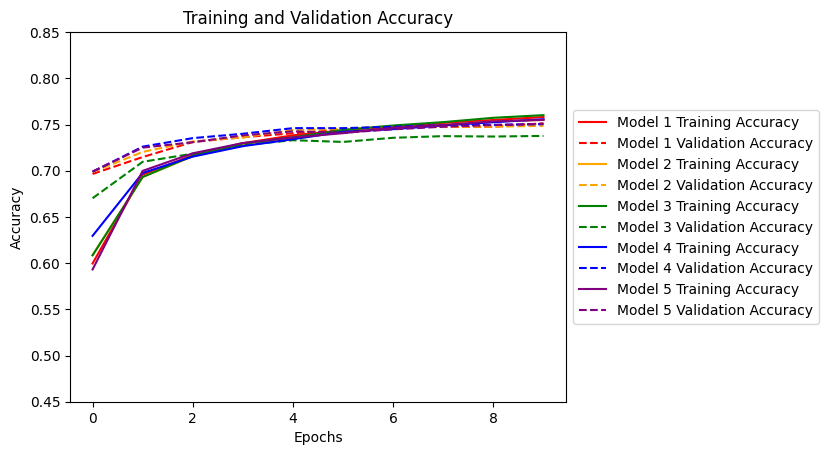

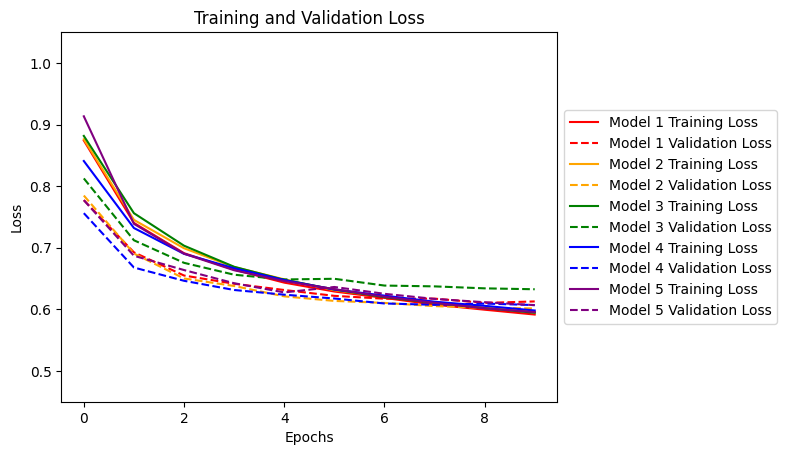

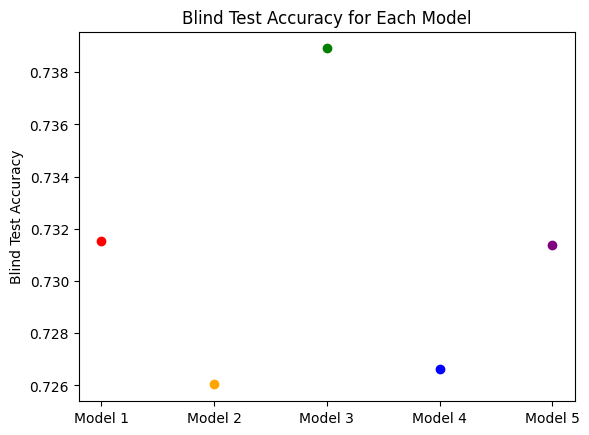

Best performing model: Model 3 with accuracy on blind test set: 0.7389114499092102


In [14]:
#evaluate default model
model_def_w11_acc_blind, model_def_w11_submodels = master_model_evaluater(get_model_default, window=11)

Starting training of model 1
Epoch 1/10
308/308 [==============================] - 4s 7ms/step - loss: 1.4333 - accuracy: 0.6030 - val_loss: 0.9631 - val_accuracy: 0.6301
Epoch 2/10
308/308 [==============================] - 2s 5ms/step - loss: 0.8093 - accuracy: 0.6945 - val_loss: 0.7957 - val_accuracy: 0.7078
Epoch 3/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7787 - accuracy: 0.7068 - val_loss: 0.7496 - val_accuracy: 0.7201
Epoch 4/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7684 - accuracy: 0.7105 - val_loss: 0.7448 - val_accuracy: 0.7234
Epoch 5/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7613 - accuracy: 0.7132 - val_loss: 0.7475 - val_accuracy: 0.7240
Epoch 6/10
308/308 [==============================] - 2s 6ms/step - loss: 0.7541 - accuracy: 0.7161 - val_loss: 0.7336 - val_accuracy: 0.7260
Epoch 7/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7478 - accuracy: 0.7188 - val_loss: 0.7380 

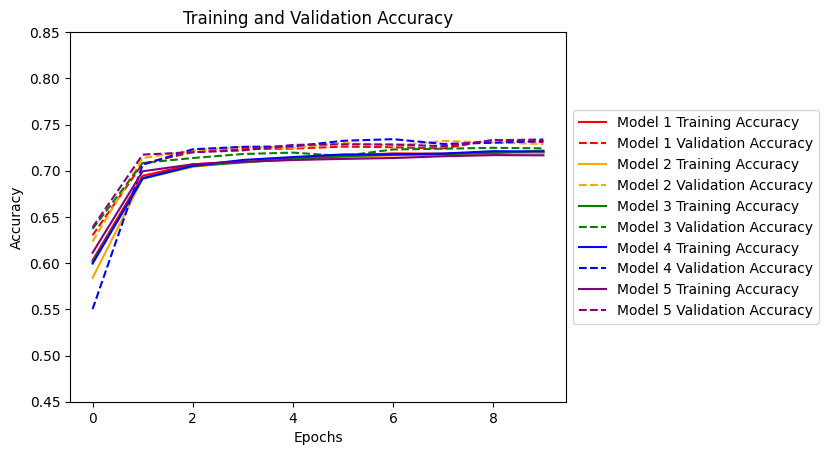

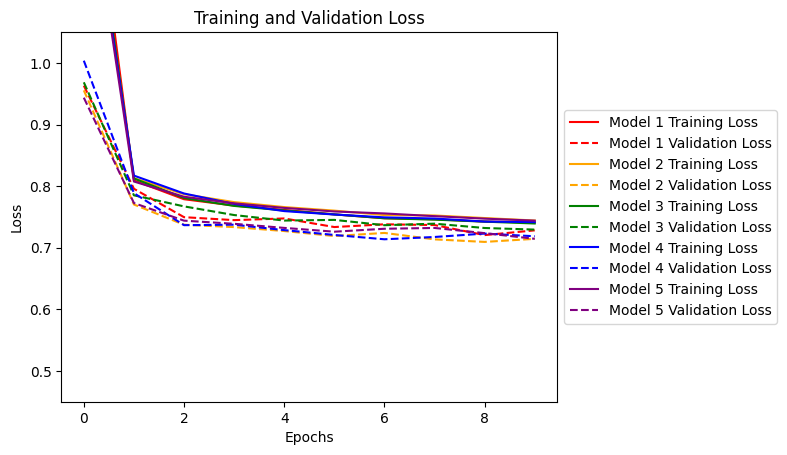

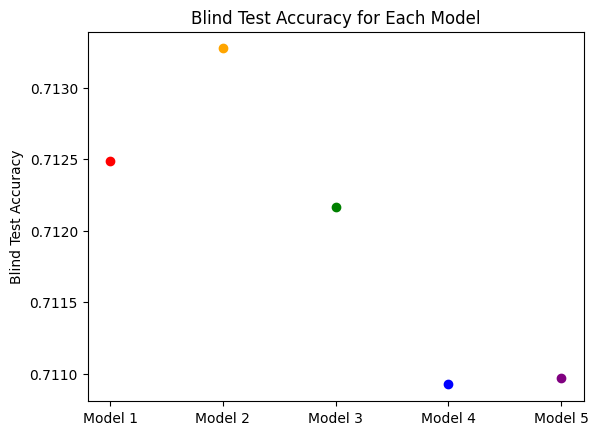

Best performing model: Model 2 with accuracy on blind test set: 0.7132741212844849


In [21]:
# evaluate model_reg
model_reg_w11_acc_blind, model_reg_w11_submodels = master_model_evaluater(get_model_reg, window=11)

Starting training of model 1
Epoch 1/10
308/308 [==============================] - 4s 6ms/step - loss: 0.8274 - accuracy: 0.6461 - val_loss: 0.7431 - val_accuracy: 0.6955
Epoch 2/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7537 - accuracy: 0.6915 - val_loss: 0.7279 - val_accuracy: 0.7002
Epoch 3/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7370 - accuracy: 0.6987 - val_loss: 0.7147 - val_accuracy: 0.7075
Epoch 4/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7202 - accuracy: 0.7057 - val_loss: 0.7015 - val_accuracy: 0.7135
Epoch 5/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7019 - accuracy: 0.7143 - val_loss: 0.6824 - val_accuracy: 0.7205
Epoch 6/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6819 - accuracy: 0.7227 - val_loss: 0.6571 - val_accuracy: 0.7294
Epoch 7/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6625 - accuracy: 0.7327 - val_loss: 0.6479 

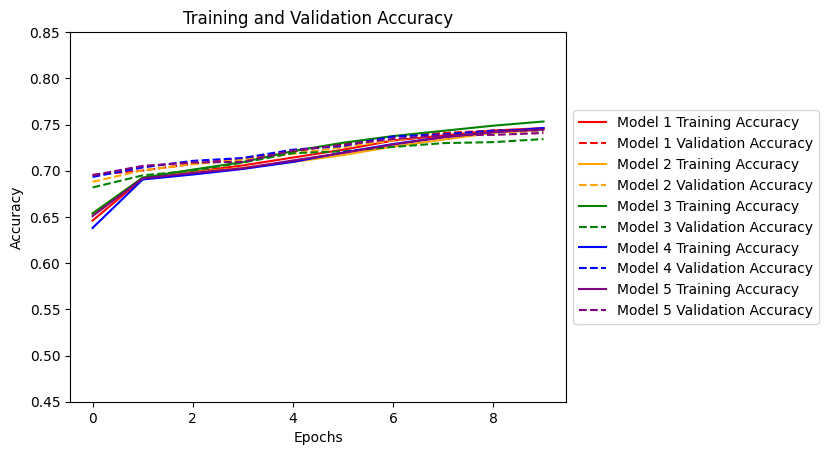

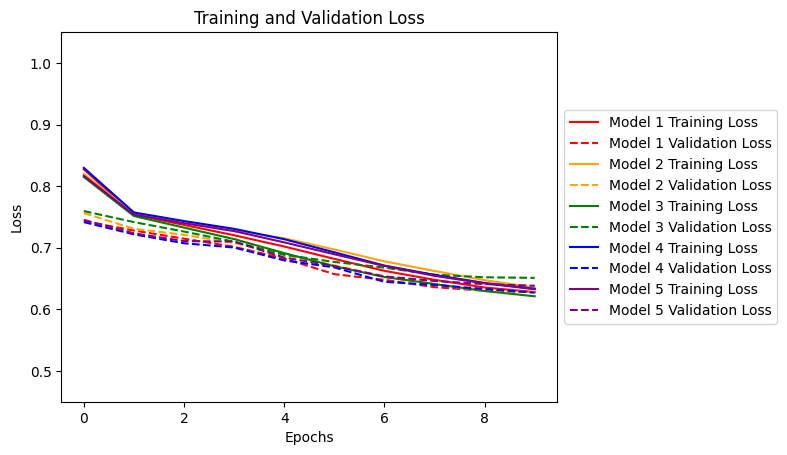

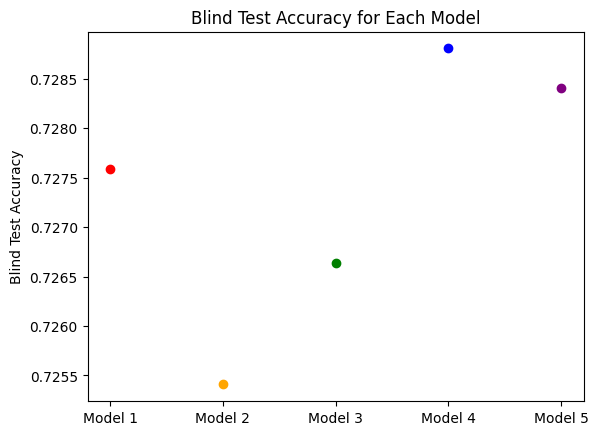

Best performing model: Model 4 with accuracy on blind test set: 0.7288045287132263


In [15]:
#evaluate model_tanh
model_tanh_w11_acc_blind, model_tanh_w11_submodels = master_model_evaluater(get_model_tanh, window=11)

Starting training of model 1
Epoch 1/10
308/308 [==============================] - 5s 7ms/step - loss: 0.8661 - accuracy: 0.6144 - val_loss: 0.7566 - val_accuracy: 0.6947
Epoch 2/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7386 - accuracy: 0.6990 - val_loss: 0.6789 - val_accuracy: 0.7201
Epoch 3/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6953 - accuracy: 0.7166 - val_loss: 0.6498 - val_accuracy: 0.7315
Epoch 4/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6654 - accuracy: 0.7278 - val_loss: 0.6472 - val_accuracy: 0.7362
Epoch 5/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6474 - accuracy: 0.7347 - val_loss: 0.6401 - val_accuracy: 0.7392
Epoch 6/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6340 - accuracy: 0.7408 - val_loss: 0.6255 - val_accuracy: 0.7457
Epoch 7/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6220 - accuracy: 0.7451 - val_loss: 0.6249 

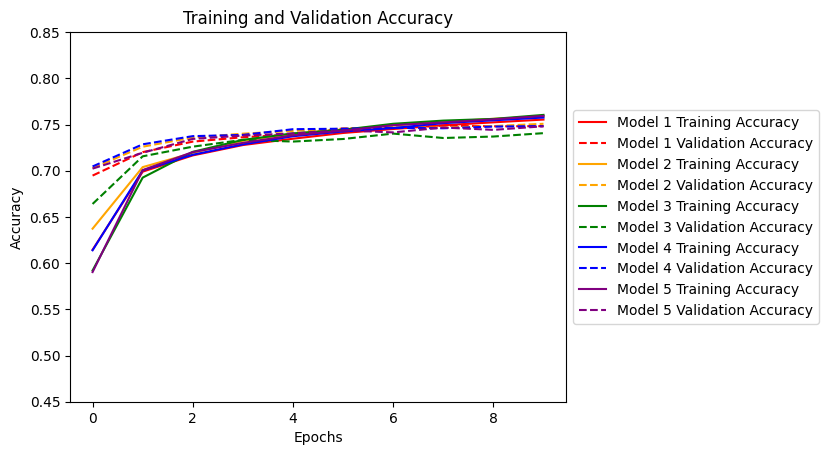

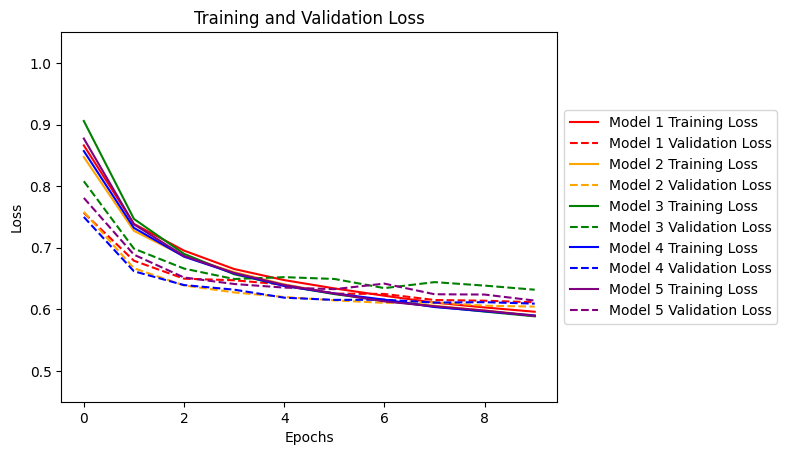

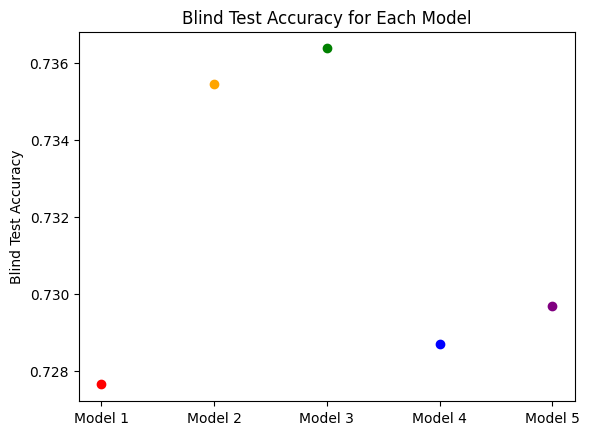

Best performing model: Model 3 with accuracy on blind test set: 0.7363685965538025


In [16]:
#evaluate model_extra_layers
model_extra_layers_w11_acc_blind, model_extra_layers_w11_submodels = master_model_evaluater(get_model_extra_layers, window=11)

Starting training of model 1
Epoch 1/10
308/308 [==============================] - 3s 6ms/step - loss: 0.8177 - accuracy: 0.6411 - val_loss: 0.7509 - val_accuracy: 0.6962
Epoch 2/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7111 - accuracy: 0.7035 - val_loss: 0.6823 - val_accuracy: 0.7145
Epoch 3/10
308/308 [==============================] - 1s 5ms/step - loss: 0.6749 - accuracy: 0.7202 - val_loss: 0.6591 - val_accuracy: 0.7255
Epoch 4/10
308/308 [==============================] - 1s 5ms/step - loss: 0.6542 - accuracy: 0.7289 - val_loss: 0.6417 - val_accuracy: 0.7344
Epoch 5/10
308/308 [==============================] - 1s 5ms/step - loss: 0.6386 - accuracy: 0.7361 - val_loss: 0.6319 - val_accuracy: 0.7377
Epoch 6/10
308/308 [==============================] - 1s 4ms/step - loss: 0.6257 - accuracy: 0.7418 - val_loss: 0.6276 - val_accuracy: 0.7403
Epoch 7/10
308/308 [==============================] - 1s 4ms/step - loss: 0.6165 - accuracy: 0.7454 - val_loss: 0.6202 

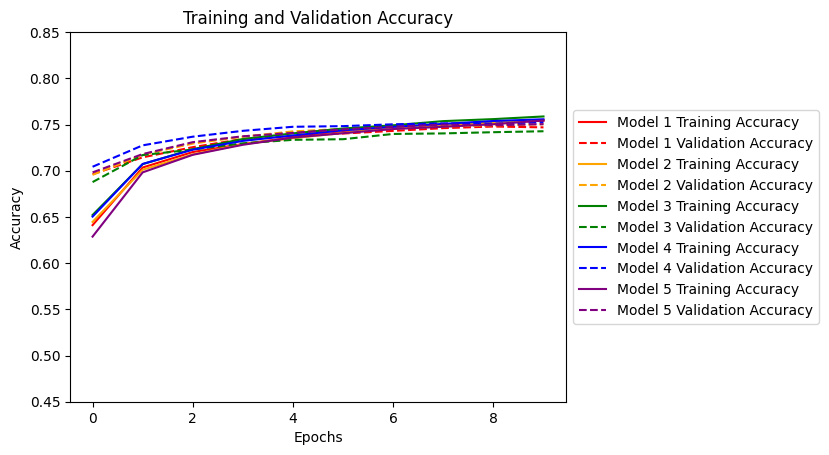

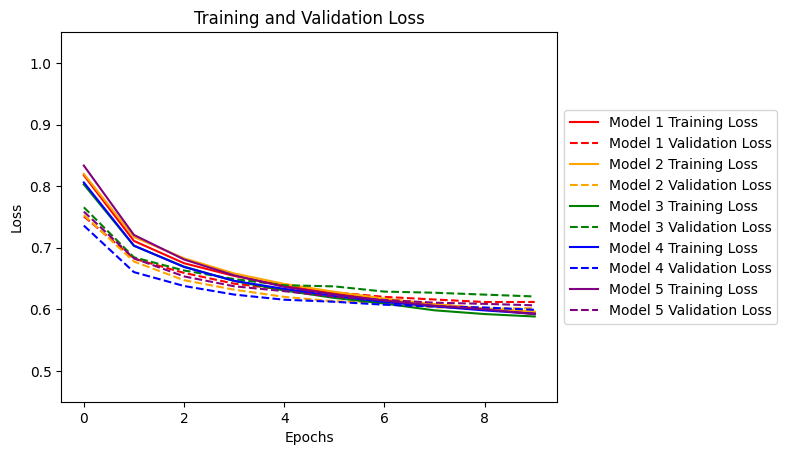

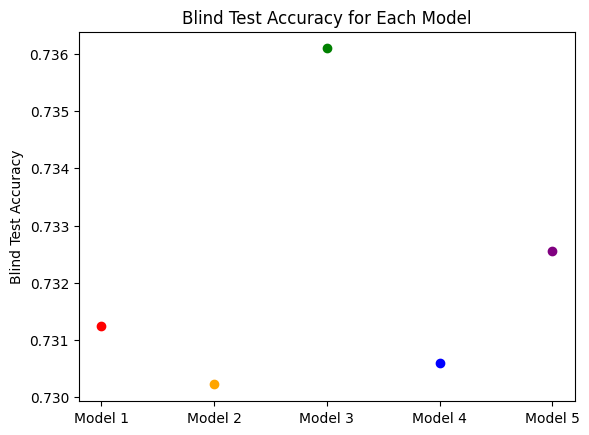

Best performing model: Model 3 with accuracy on blind test set: 0.7360950112342834


In [17]:
# evaluate model_less_layers
model_less_layers_w11_acc_blind, model_less_layers_w11_submodels = master_model_evaluater(get_model_less_layers, window=11)

# 7. Model training for window size 13

In [22]:
window = 13

In [23]:
# fetch and print cross-validation data for each fold with specied window
for cv_fold in range(1, 6):
    x_train_cv, y_train_cv = fetch_cv_data(window, cv=cv_fold, train=True)
    globals()[f'x_train_cv{cv_fold}'] = x_train_cv
    globals()[f'y_train_cv{cv_fold}'] = y_train_cv

    x_test_cv, y_test_cv = fetch_cv_data(window, cv=cv_fold, train=False)
    globals()[f'x_test_cv{cv_fold}'] = x_test_cv
    globals()[f'y_test_cv{cv_fold}'] = y_test_cv


# fetch and print blind test data
x_test_blind, y_test_blind = fetch_blind_test_data(window)

You are getting the train partition of cross-validation set 1
x_train_cv1: (157415, 13, 40), y_train_cv1: (157415, 3)
You are getting the test partition of cross-validation set 1
x_test_cv1: (40729, 13, 40), y_test_cv1: (40729, 3)
You are getting the train partition of cross-validation set 2
x_train_cv2: (158838, 13, 40), y_train_cv2: (158838, 3)
You are getting the test partition of cross-validation set 2
x_test_cv2: (39306, 13, 40), y_test_cv2: (39306, 3)
You are getting the train partition of cross-validation set 3
x_train_cv3: (158463, 13, 40), y_train_cv3: (158463, 3)
You are getting the test partition of cross-validation set 3
x_test_cv3: (39681, 13, 40), y_test_cv3: (39681, 3)
You are getting the train partition of cross-validation set 4
x_train_cv4: (159359, 13, 40), y_train_cv4: (159359, 3)
You are getting the test partition of cross-validation set 4
x_test_cv4: (38785, 13, 40), y_test_cv4: (38785, 3)
You are getting the train partition of cross-validation set 5
x_train_cv5: (

Starting training of model 1
Epoch 1/10
308/308 [==============================] - 5s 7ms/step - loss: 0.9211 - accuracy: 0.5684 - val_loss: 0.7681 - val_accuracy: 0.6862
Epoch 2/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7465 - accuracy: 0.6963 - val_loss: 0.6928 - val_accuracy: 0.7175
Epoch 3/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6935 - accuracy: 0.7195 - val_loss: 0.6481 - val_accuracy: 0.7331
Epoch 4/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6573 - accuracy: 0.7330 - val_loss: 0.6265 - val_accuracy: 0.7427
Epoch 5/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6325 - accuracy: 0.7444 - val_loss: 0.6178 - val_accuracy: 0.7474
Epoch 6/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6153 - accuracy: 0.7516 - val_loss: 0.6096 - val_accuracy: 0.7493
Epoch 7/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6025 - accuracy: 0.7559 - val_loss: 0.6051 

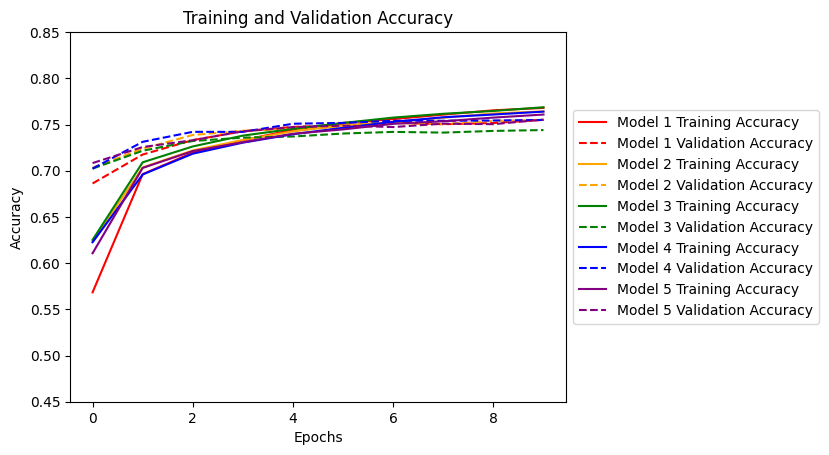

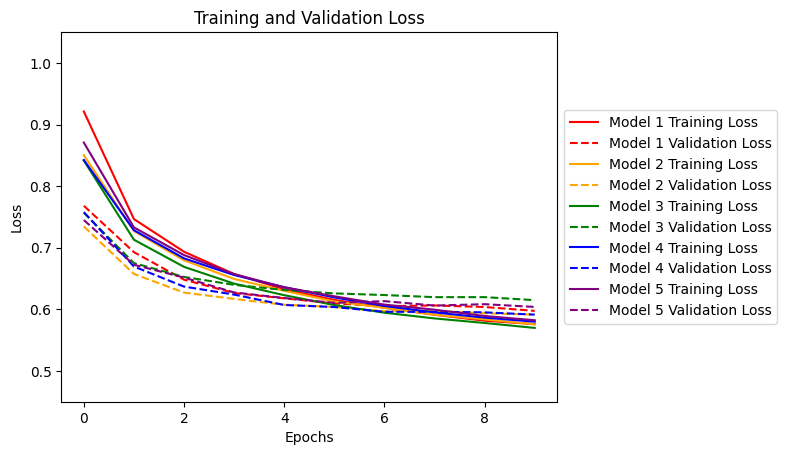

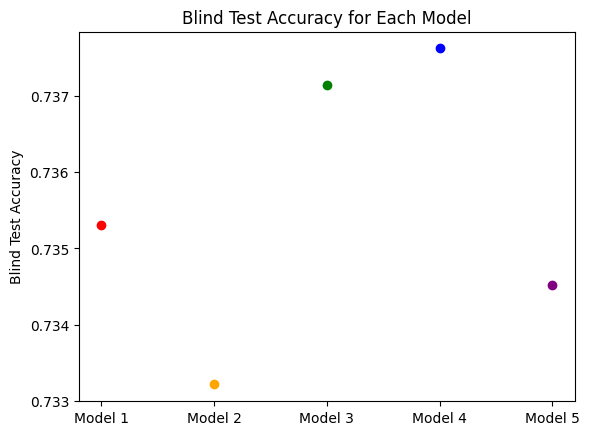

Best performing model: Model 4 with accuracy on blind test set: 0.737623929977417


In [24]:
# evaluate model_default
model_def_w13_acc_blind, model_def_w13_submodels = master_model_evaluater(get_model_default, window=13)

Starting training of model 1
Epoch 1/10
308/308 [==============================] - 4s 7ms/step - loss: 1.3669 - accuracy: 0.6283 - val_loss: 1.0274 - val_accuracy: 0.5362
Epoch 2/10
308/308 [==============================] - 2s 5ms/step - loss: 0.8004 - accuracy: 0.7039 - val_loss: 0.7823 - val_accuracy: 0.7126
Epoch 3/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7782 - accuracy: 0.7100 - val_loss: 0.7538 - val_accuracy: 0.7232
Epoch 4/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7641 - accuracy: 0.7164 - val_loss: 0.7358 - val_accuracy: 0.7237
Epoch 5/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7540 - accuracy: 0.7195 - val_loss: 0.7332 - val_accuracy: 0.7334
Epoch 6/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7519 - accuracy: 0.7205 - val_loss: 0.7373 - val_accuracy: 0.7269
Epoch 7/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7462 - accuracy: 0.7231 - val_loss: 0.7279 

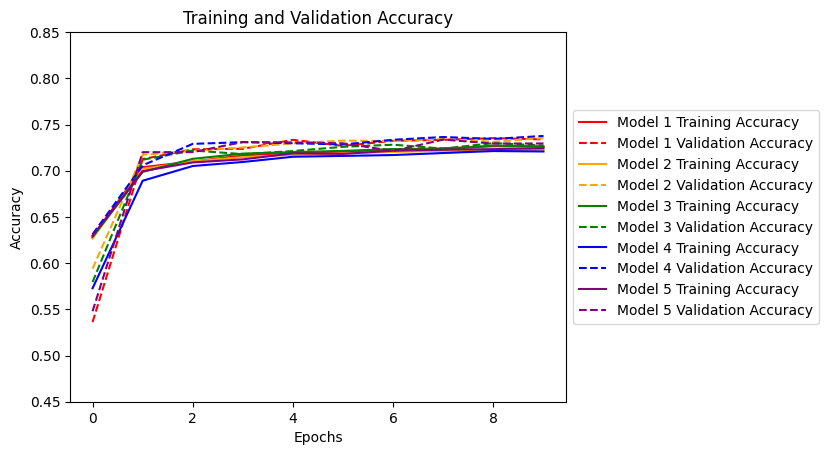

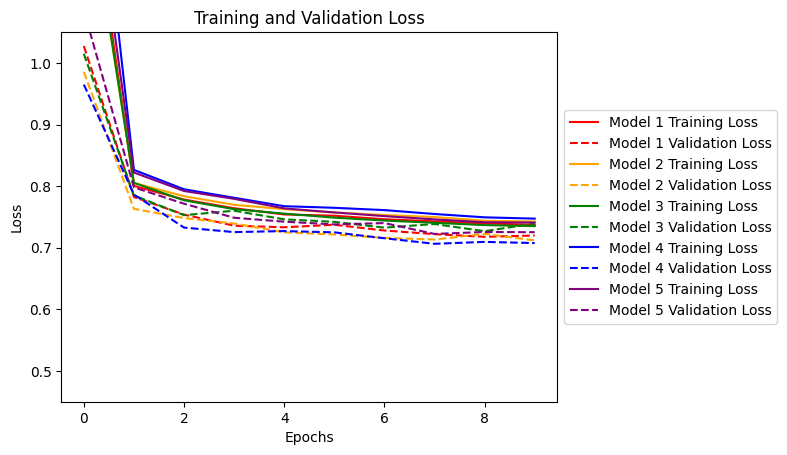

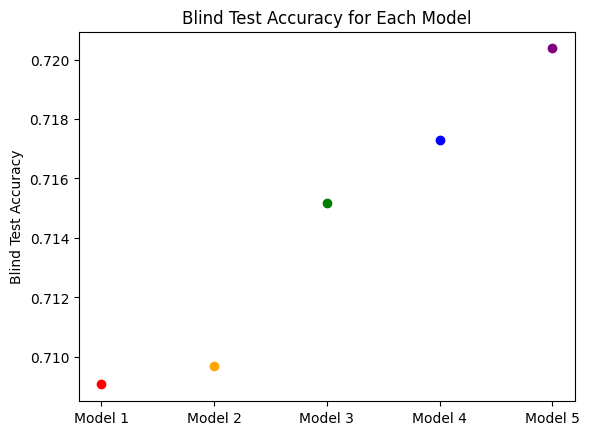

Best performing model: Model 5 with accuracy on blind test set: 0.720371425151825


In [25]:
# evaluate model_reg
model_reg_w13_acc_blind, model_reg_w13_submodels = master_model_evaluater(get_model_reg, window=13)

Starting training of model 1
Epoch 1/10
308/308 [==============================] - 4s 7ms/step - loss: 0.8051 - accuracy: 0.6586 - val_loss: 0.7344 - val_accuracy: 0.7005
Epoch 2/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7429 - accuracy: 0.6959 - val_loss: 0.7183 - val_accuracy: 0.7078
Epoch 3/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7285 - accuracy: 0.7032 - val_loss: 0.7067 - val_accuracy: 0.7103
Epoch 4/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7154 - accuracy: 0.7094 - val_loss: 0.6996 - val_accuracy: 0.7128
Epoch 5/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7004 - accuracy: 0.7160 - val_loss: 0.6812 - val_accuracy: 0.7204
Epoch 6/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6804 - accuracy: 0.7251 - val_loss: 0.6631 - val_accuracy: 0.7286
Epoch 7/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6599 - accuracy: 0.7351 - val_loss: 0.6456 

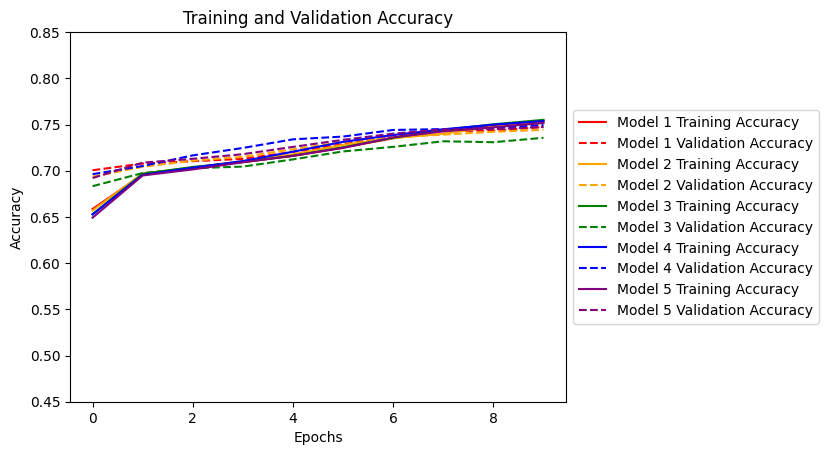

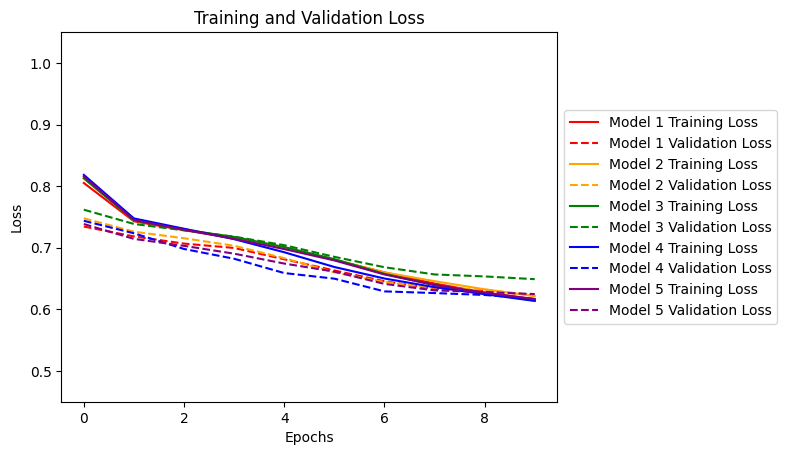

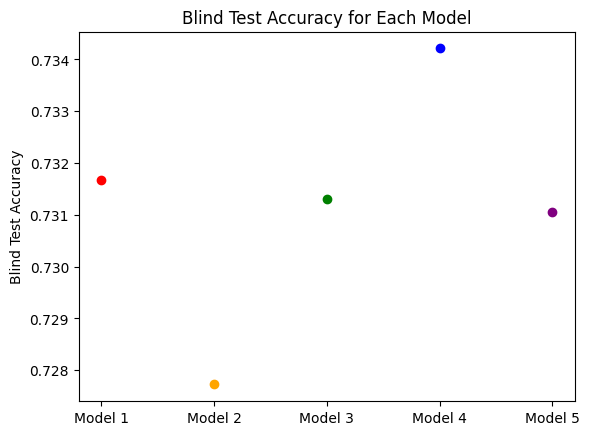

Best performing model: Model 4 with accuracy on blind test set: 0.7342120409011841


In [26]:
# evaluate model_tanh
model_tanh_w13_acc_blind, model_tanh_w13_submodels = master_model_evaluater(get_model_tanh, window=13)

Starting training of model 1
Epoch 1/10
308/308 [==============================] - 5s 7ms/step - loss: 0.8823 - accuracy: 0.6002 - val_loss: 0.7812 - val_accuracy: 0.6833
Epoch 2/10
308/308 [==============================] - 2s 6ms/step - loss: 0.7370 - accuracy: 0.7024 - val_loss: 0.6805 - val_accuracy: 0.7233
Epoch 3/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6788 - accuracy: 0.7262 - val_loss: 0.6383 - val_accuracy: 0.7379
Epoch 4/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6486 - accuracy: 0.7378 - val_loss: 0.6228 - val_accuracy: 0.7446
Epoch 5/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6288 - accuracy: 0.7456 - val_loss: 0.6191 - val_accuracy: 0.7469
Epoch 6/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6134 - accuracy: 0.7519 - val_loss: 0.6196 - val_accuracy: 0.7471
Epoch 7/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6026 - accuracy: 0.7554 - val_loss: 0.6101 

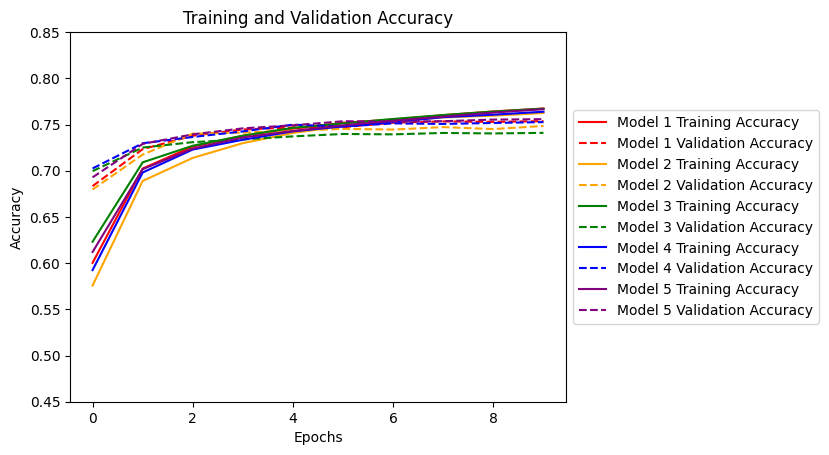

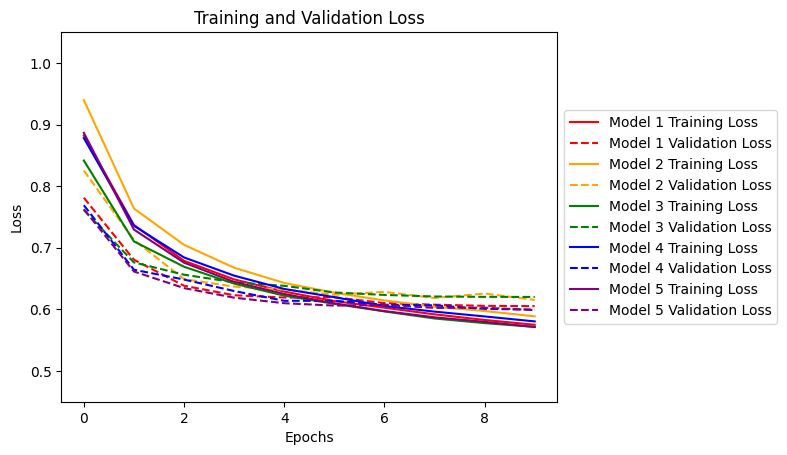

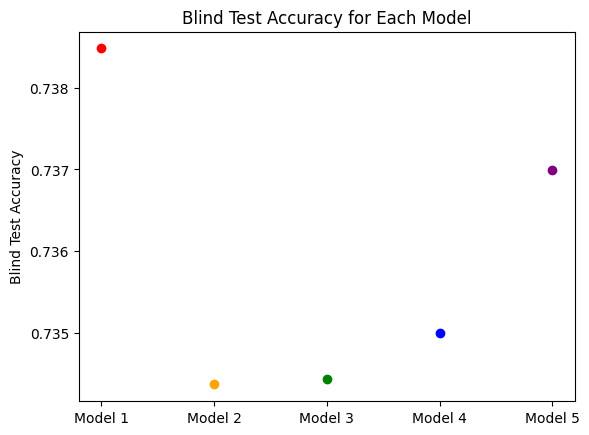

Best performing model: Model 1 with accuracy on blind test set: 0.7384768724441528


In [27]:
# evaluate model_extra_layers
model_extra_layers_w13_acc_blind, model_extra_layers_w13_submodels = master_model_evaluater(get_model_extra_layers, window=13)

Starting training of model 1
Epoch 1/10
308/308 [==============================] - 4s 9ms/step - loss: 0.8110 - accuracy: 0.6439 - val_loss: 0.7407 - val_accuracy: 0.7037
Epoch 2/10
308/308 [==============================] - 1s 5ms/step - loss: 0.7035 - accuracy: 0.7066 - val_loss: 0.6783 - val_accuracy: 0.7203
Epoch 3/10
308/308 [==============================] - 1s 5ms/step - loss: 0.6649 - accuracy: 0.7246 - val_loss: 0.6433 - val_accuracy: 0.7342
Epoch 4/10
308/308 [==============================] - 1s 5ms/step - loss: 0.6380 - accuracy: 0.7360 - val_loss: 0.6273 - val_accuracy: 0.7428
Epoch 5/10
308/308 [==============================] - 1s 5ms/step - loss: 0.6212 - accuracy: 0.7424 - val_loss: 0.6140 - val_accuracy: 0.7449
Epoch 6/10
308/308 [==============================] - 1s 5ms/step - loss: 0.6089 - accuracy: 0.7488 - val_loss: 0.6111 - val_accuracy: 0.7491
Epoch 7/10
308/308 [==============================] - 1s 5ms/step - loss: 0.5985 - accuracy: 0.7526 - val_loss: 0.6044 

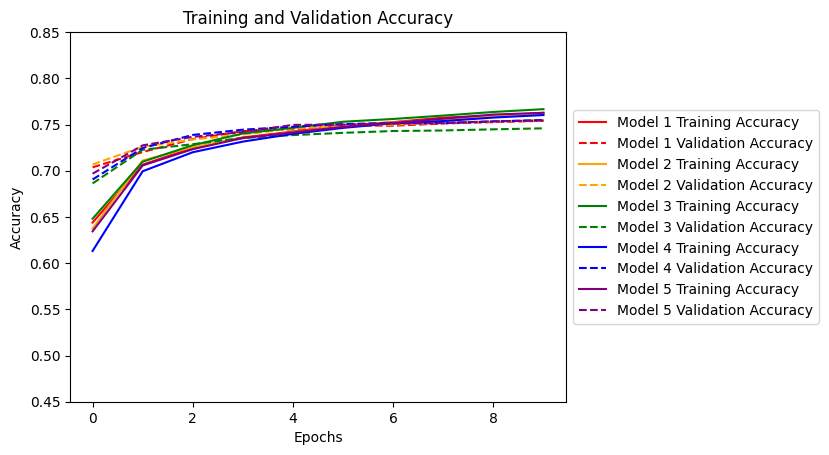

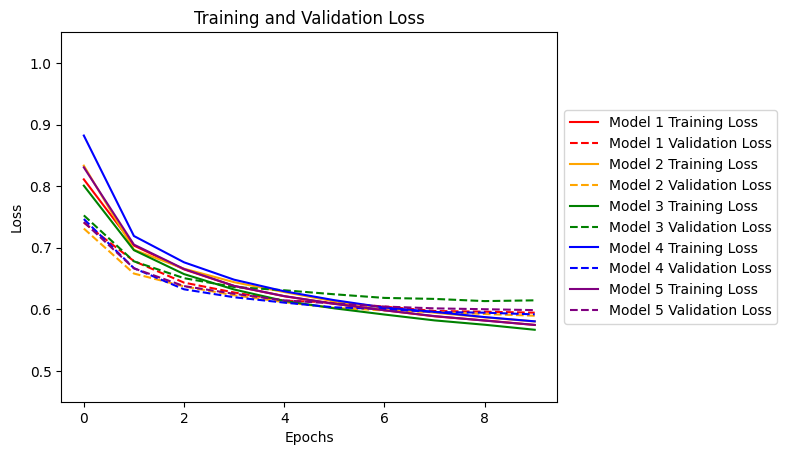

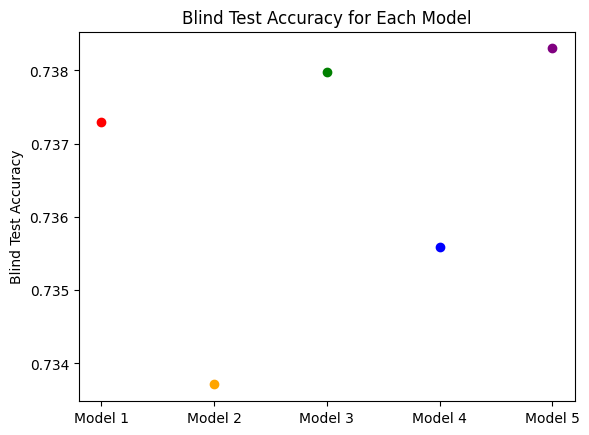

Best performing model: Model 5 with accuracy on blind test set: 0.7382998466491699


In [28]:
# evaluate model_less_layers
model_less_layers_w13_acc_blind, model_less_layers_w13_submodels = master_model_evaluater(get_model_less_layers, window=13)

# 8. Model training for window size 15

In [29]:
window = 15

In [30]:
# fetch and print cross-validation data for each fold with specied window
for cv_fold in range(1, 6):
    x_train_cv, y_train_cv = fetch_cv_data(window, cv=cv_fold, train=True)
    globals()[f'x_train_cv{cv_fold}'] = x_train_cv
    globals()[f'y_train_cv{cv_fold}'] = y_train_cv

    x_test_cv, y_test_cv = fetch_cv_data(window, cv=cv_fold, train=False)
    globals()[f'x_test_cv{cv_fold}'] = x_test_cv
    globals()[f'y_test_cv{cv_fold}'] = y_test_cv


# fetch and print blind test data
x_test_blind, y_test_blind = fetch_blind_test_data(window)

You are getting the train partition of cross-validation set 1
x_train_cv1: (157415, 15, 40), y_train_cv1: (157415, 3)
You are getting the test partition of cross-validation set 1
x_test_cv1: (40729, 15, 40), y_test_cv1: (40729, 3)
You are getting the train partition of cross-validation set 2
x_train_cv2: (158838, 15, 40), y_train_cv2: (158838, 3)
You are getting the test partition of cross-validation set 2
x_test_cv2: (39306, 15, 40), y_test_cv2: (39306, 3)
You are getting the train partition of cross-validation set 3
x_train_cv3: (158463, 15, 40), y_train_cv3: (158463, 3)
You are getting the test partition of cross-validation set 3
x_test_cv3: (39681, 15, 40), y_test_cv3: (39681, 3)
You are getting the train partition of cross-validation set 4
x_train_cv4: (159359, 15, 40), y_train_cv4: (159359, 3)
You are getting the test partition of cross-validation set 4
x_test_cv4: (38785, 15, 40), y_test_cv4: (38785, 3)
You are getting the train partition of cross-validation set 5
x_train_cv5: (

Starting training of model 1
Epoch 1/10
308/308 [==============================] - 4s 7ms/step - loss: 0.8849 - accuracy: 0.6050 - val_loss: 0.7638 - val_accuracy: 0.6998
Epoch 2/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7340 - accuracy: 0.7040 - val_loss: 0.6684 - val_accuracy: 0.7260
Epoch 3/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6783 - accuracy: 0.7260 - val_loss: 0.6385 - val_accuracy: 0.7367
Epoch 4/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6456 - accuracy: 0.7378 - val_loss: 0.6193 - val_accuracy: 0.7446
Epoch 5/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6245 - accuracy: 0.7468 - val_loss: 0.6132 - val_accuracy: 0.7498
Epoch 6/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6060 - accuracy: 0.7539 - val_loss: 0.6028 - val_accuracy: 0.7519
Epoch 7/10
308/308 [==============================] - 2s 5ms/step - loss: 0.5925 - accuracy: 0.7595 - val_loss: 0.5986 

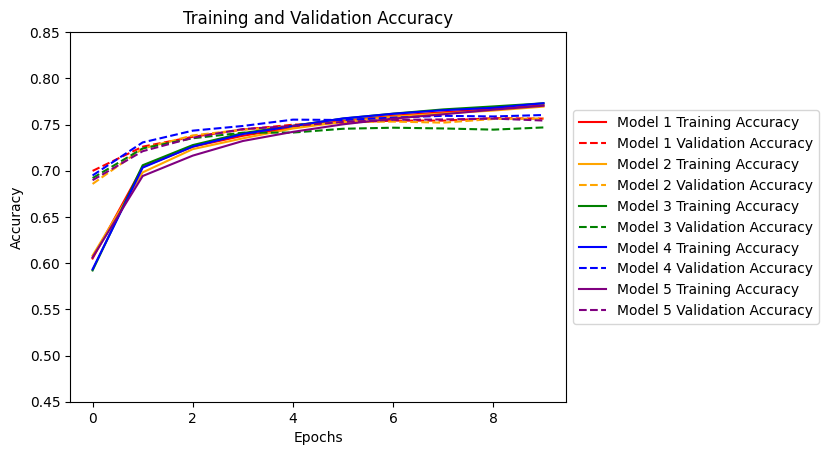

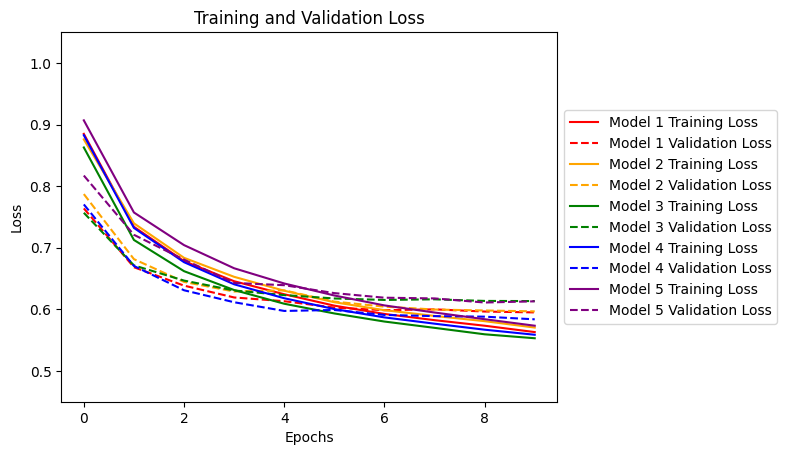

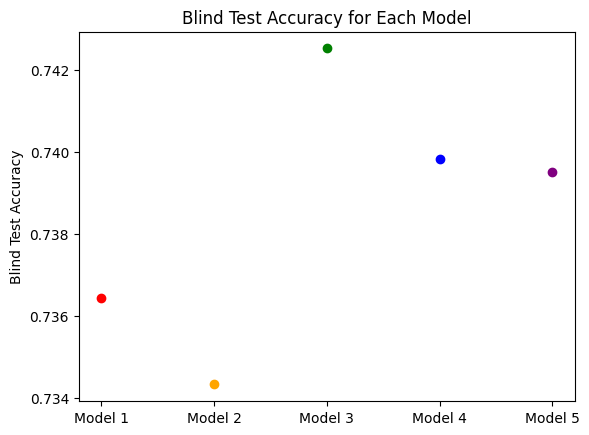

Best performing model: Model 3 with accuracy on blind test set: 0.74253249168396


In [31]:
# evaluate model_default
model_def_w15_acc_blind, model_def_w15_submodels = master_model_evaluater(get_model_default, window=15)

Starting training of model 1
Epoch 1/10
308/308 [==============================] - 4s 7ms/step - loss: 1.2858 - accuracy: 0.6066 - val_loss: 0.9555 - val_accuracy: 0.6360
Epoch 2/10
308/308 [==============================] - 2s 5ms/step - loss: 0.8061 - accuracy: 0.6954 - val_loss: 0.7686 - val_accuracy: 0.7209
Epoch 3/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7826 - accuracy: 0.7089 - val_loss: 0.7502 - val_accuracy: 0.7242
Epoch 4/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7681 - accuracy: 0.7160 - val_loss: 0.7297 - val_accuracy: 0.7339
Epoch 5/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7573 - accuracy: 0.7209 - val_loss: 0.7420 - val_accuracy: 0.7234
Epoch 6/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7505 - accuracy: 0.7235 - val_loss: 0.7219 - val_accuracy: 0.7358
Epoch 7/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7444 - accuracy: 0.7247 - val_loss: 0.7179 

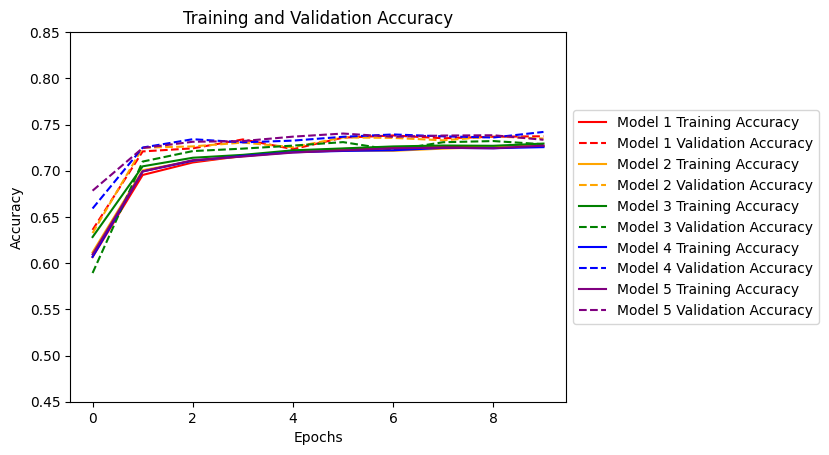

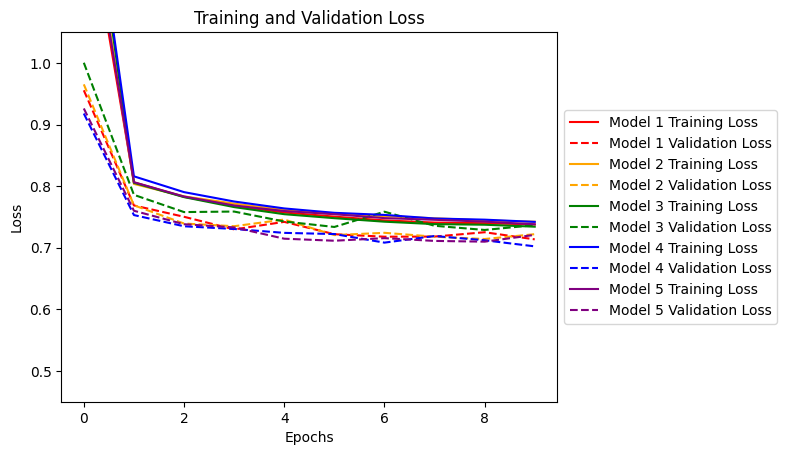

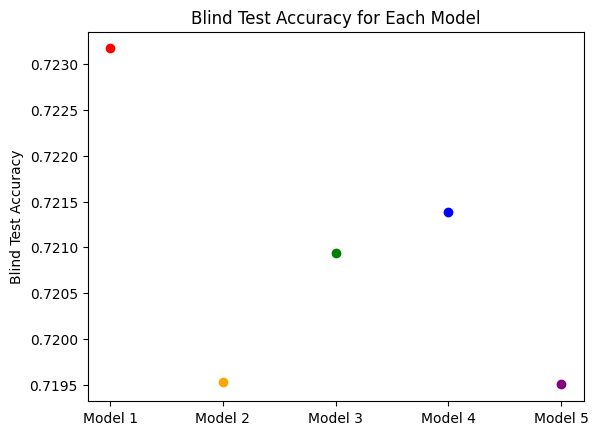

Best performing model: Model 1 with accuracy on blind test set: 0.7231717705726624


In [32]:
# evaluate model_reg
model_reg_w15_acc_blind, model_reg_w15_submodels = master_model_evaluater(get_model_reg, window=15)

Starting training of model 1
Epoch 1/10
308/308 [==============================] - 4s 7ms/step - loss: 0.8085 - accuracy: 0.6563 - val_loss: 0.7287 - val_accuracy: 0.7038
Epoch 2/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7387 - accuracy: 0.6986 - val_loss: 0.7153 - val_accuracy: 0.7086
Epoch 3/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7232 - accuracy: 0.7063 - val_loss: 0.7052 - val_accuracy: 0.7115
Epoch 4/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7098 - accuracy: 0.7114 - val_loss: 0.7013 - val_accuracy: 0.7130
Epoch 5/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6961 - accuracy: 0.7188 - val_loss: 0.6817 - val_accuracy: 0.7198
Epoch 6/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6743 - accuracy: 0.7277 - val_loss: 0.6597 - val_accuracy: 0.7306
Epoch 7/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6505 - accuracy: 0.7390 - val_loss: 0.6373 

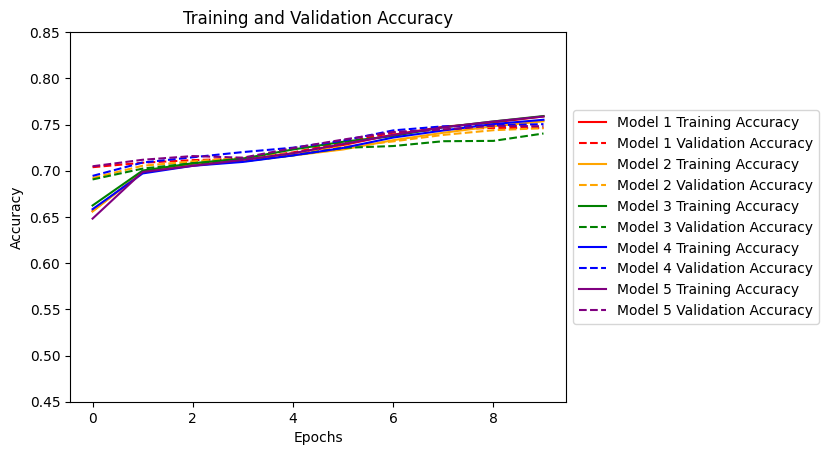

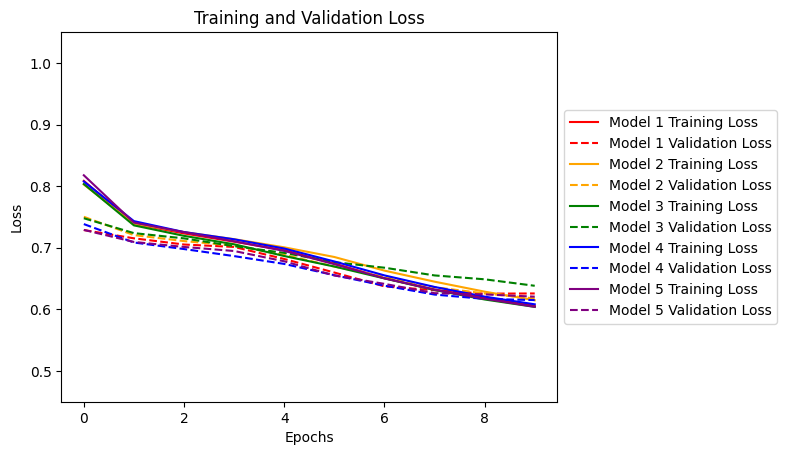

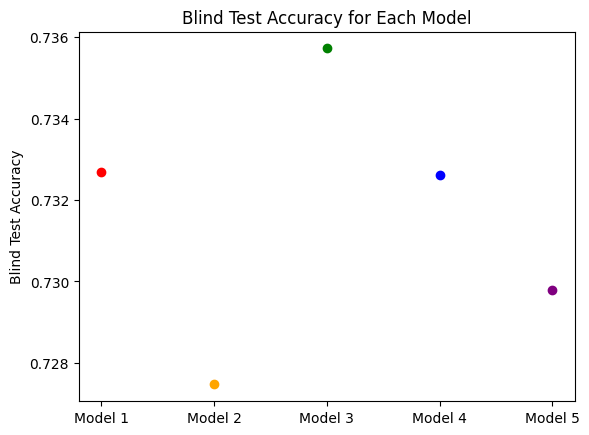

Best performing model: Model 3 with accuracy on blind test set: 0.7357248663902283


In [33]:
# evaluate model_tanh
model_tanh_w15_acc_blind, model_tanh_w15_submodels = master_model_evaluater(get_model_tanh, window=15)

Starting training of model 1
Epoch 1/10
308/308 [==============================] - 5s 7ms/step - loss: 0.8795 - accuracy: 0.5891 - val_loss: 0.7728 - val_accuracy: 0.6912
Epoch 2/10
308/308 [==============================] - 2s 6ms/step - loss: 0.7272 - accuracy: 0.7013 - val_loss: 0.6773 - val_accuracy: 0.7285
Epoch 3/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6751 - accuracy: 0.7228 - val_loss: 0.6481 - val_accuracy: 0.7406
Epoch 4/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6411 - accuracy: 0.7393 - val_loss: 0.6263 - val_accuracy: 0.7456
Epoch 5/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6175 - accuracy: 0.7481 - val_loss: 0.6119 - val_accuracy: 0.7509
Epoch 6/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6033 - accuracy: 0.7534 - val_loss: 0.6034 - val_accuracy: 0.7521
Epoch 7/10
308/308 [==============================] - 2s 6ms/step - loss: 0.5910 - accuracy: 0.7585 - val_loss: 0.5965 

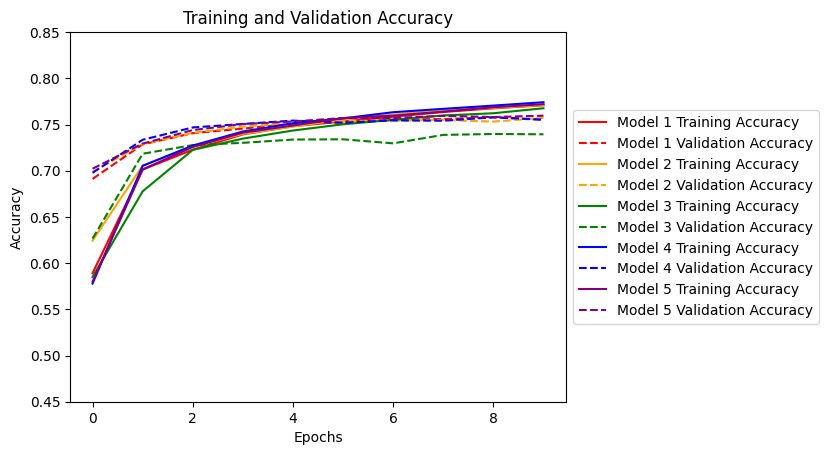

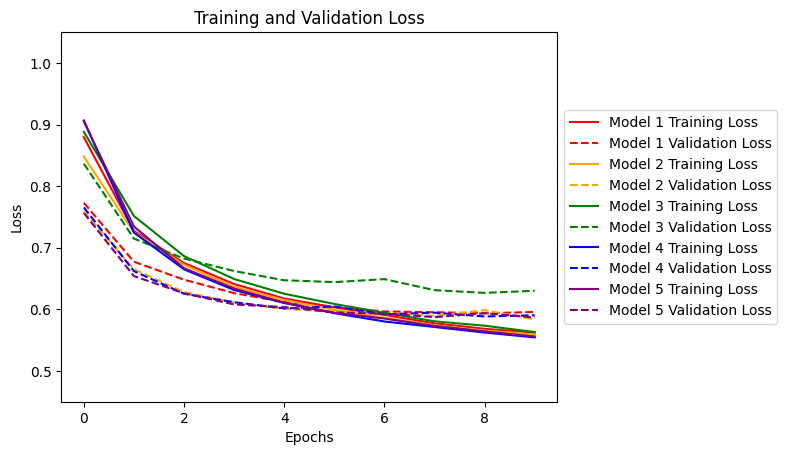

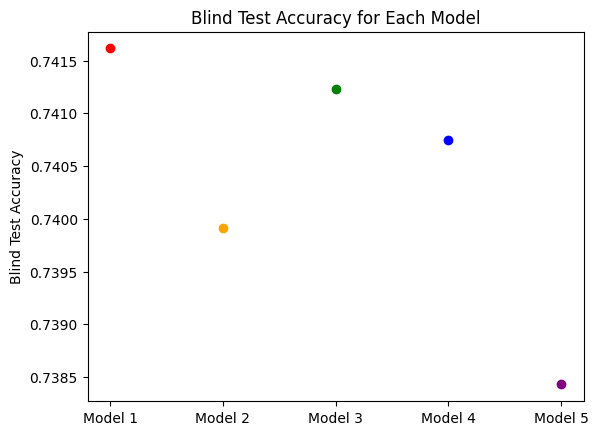

Best performing model: Model 1 with accuracy on blind test set: 0.7416151762008667


In [34]:
# evaluate model_extra_layers
model_extra_layers_w15_acc_blind, model_extra_layers_w15_submodels = master_model_evaluater(get_model_extra_layers, window=15)

Starting training of model 1
Epoch 1/10
308/308 [==============================] - 3s 6ms/step - loss: 0.8126 - accuracy: 0.6469 - val_loss: 0.7396 - val_accuracy: 0.6971
Epoch 2/10
308/308 [==============================] - 1s 5ms/step - loss: 0.7042 - accuracy: 0.7074 - val_loss: 0.6819 - val_accuracy: 0.7175
Epoch 3/10
308/308 [==============================] - 1s 4ms/step - loss: 0.6655 - accuracy: 0.7246 - val_loss: 0.6444 - val_accuracy: 0.7336
Epoch 4/10
308/308 [==============================] - 1s 5ms/step - loss: 0.6362 - accuracy: 0.7381 - val_loss: 0.6231 - val_accuracy: 0.7415
Epoch 5/10
308/308 [==============================] - 1s 5ms/step - loss: 0.6142 - accuracy: 0.7474 - val_loss: 0.6116 - val_accuracy: 0.7468
Epoch 6/10
308/308 [==============================] - 1s 5ms/step - loss: 0.5997 - accuracy: 0.7522 - val_loss: 0.6040 - val_accuracy: 0.7490
Epoch 7/10
308/308 [==============================] - 1s 5ms/step - loss: 0.5885 - accuracy: 0.7583 - val_loss: 0.5987 

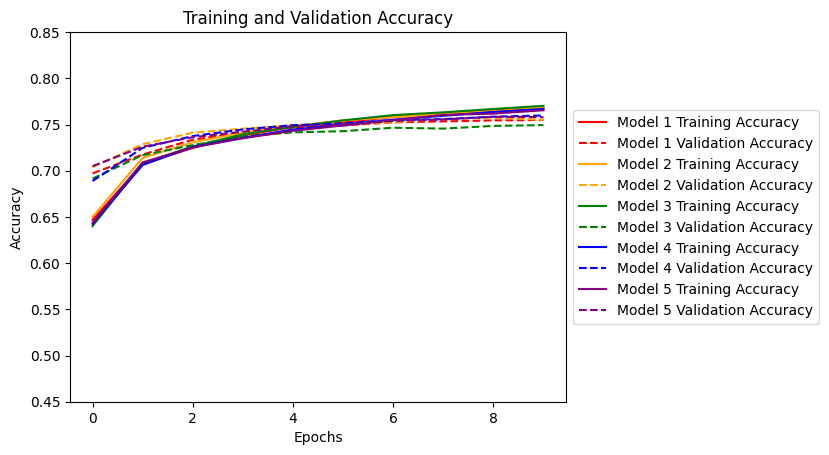

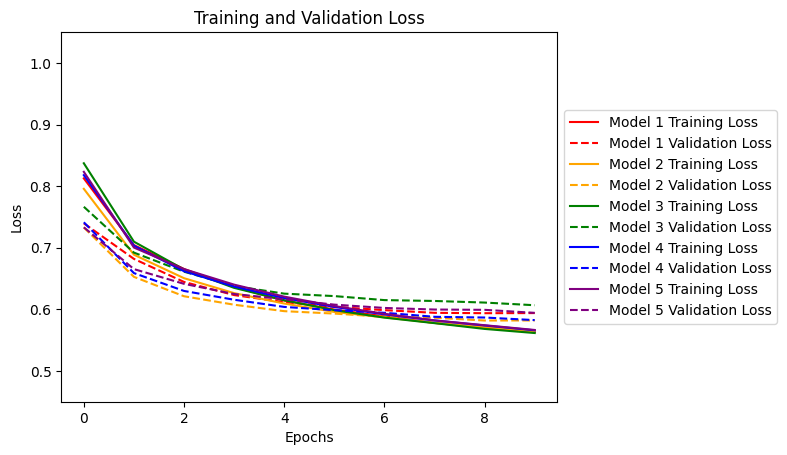

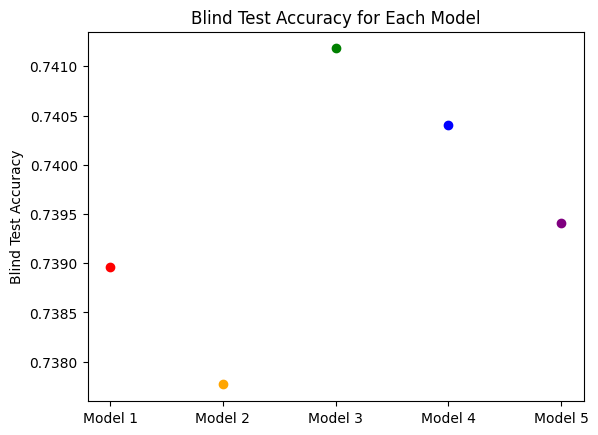

Best performing model: Model 3 with accuracy on blind test set: 0.7411806583404541


In [35]:
# evaluate model_less_layers
model_less_layers_w15_acc_blind, model_less_layers_w15_submodels = master_model_evaluater(get_model_less_layers, window=15)

# 9. Model training for window size 17

In [36]:
window = 17

In [37]:
# fetch and print cross-validation data for each fold with specied window
for cv_fold in range(1, 6):
    x_train_cv, y_train_cv = fetch_cv_data(window, cv=cv_fold, train=True)
    globals()[f'x_train_cv{cv_fold}'] = x_train_cv
    globals()[f'y_train_cv{cv_fold}'] = y_train_cv

    x_test_cv, y_test_cv = fetch_cv_data(window, cv=cv_fold, train=False)
    globals()[f'x_test_cv{cv_fold}'] = x_test_cv
    globals()[f'y_test_cv{cv_fold}'] = y_test_cv


# fetch and print blind test data
x_test_blind, y_test_blind = fetch_blind_test_data(window)

You are getting the train partition of cross-validation set 1
x_train_cv1: (157415, 17, 40), y_train_cv1: (157415, 3)
You are getting the test partition of cross-validation set 1
x_test_cv1: (40729, 17, 40), y_test_cv1: (40729, 3)
You are getting the train partition of cross-validation set 2
x_train_cv2: (158838, 17, 40), y_train_cv2: (158838, 3)
You are getting the test partition of cross-validation set 2
x_test_cv2: (39306, 17, 40), y_test_cv2: (39306, 3)
You are getting the train partition of cross-validation set 3
x_train_cv3: (158463, 17, 40), y_train_cv3: (158463, 3)
You are getting the test partition of cross-validation set 3
x_test_cv3: (39681, 17, 40), y_test_cv3: (39681, 3)
You are getting the train partition of cross-validation set 4
x_train_cv4: (159359, 17, 40), y_train_cv4: (159359, 3)
You are getting the test partition of cross-validation set 4
x_test_cv4: (38785, 17, 40), y_test_cv4: (38785, 3)
You are getting the train partition of cross-validation set 5
x_train_cv5: (

Starting training of model 1
Epoch 1/10
308/308 [==============================] - 5s 7ms/step - loss: 0.8780 - accuracy: 0.6006 - val_loss: 0.7370 - val_accuracy: 0.7035
Epoch 2/10
308/308 [==============================] - 2s 6ms/step - loss: 0.7296 - accuracy: 0.7042 - val_loss: 0.6665 - val_accuracy: 0.7247
Epoch 3/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6801 - accuracy: 0.7239 - val_loss: 0.6350 - val_accuracy: 0.7395
Epoch 4/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6466 - accuracy: 0.7377 - val_loss: 0.6218 - val_accuracy: 0.7424
Epoch 5/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6225 - accuracy: 0.7469 - val_loss: 0.6103 - val_accuracy: 0.7493
Epoch 6/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6039 - accuracy: 0.7542 - val_loss: 0.6034 - val_accuracy: 0.7519
Epoch 7/10
308/308 [==============================] - 2s 6ms/step - loss: 0.5890 - accuracy: 0.7608 - val_loss: 0.5975 

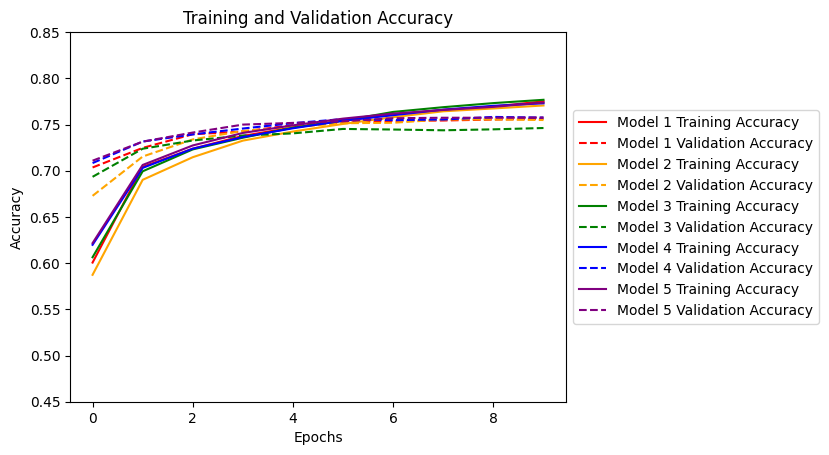

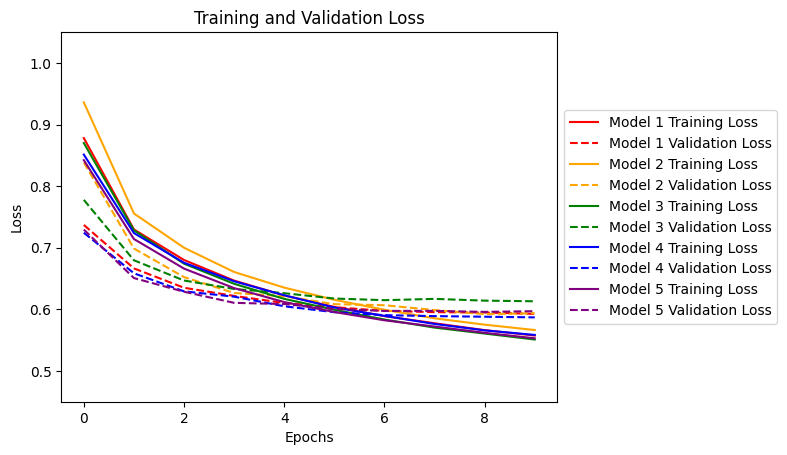

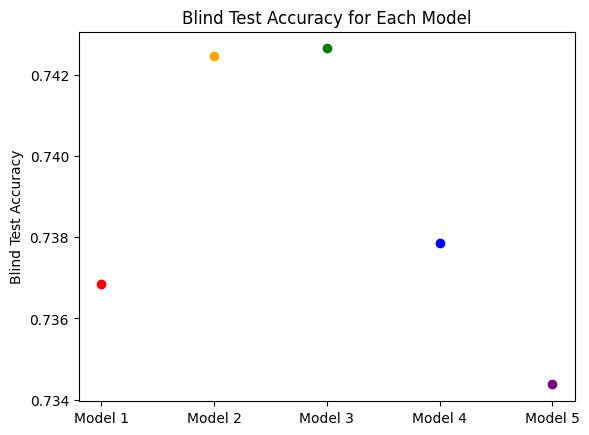

Best performing model: Model 3 with accuracy on blind test set: 0.7426451444625854


In [38]:
# evaluate model_default
model_def_w17_acc_blind, model_def_w17_submodels = master_model_evaluater(get_model_default, window=17)

Starting training of model 1
Epoch 1/10
308/308 [==============================] - 4s 7ms/step - loss: 1.3143 - accuracy: 0.6190 - val_loss: 0.9266 - val_accuracy: 0.6730
Epoch 2/10
308/308 [==============================] - 2s 6ms/step - loss: 0.8088 - accuracy: 0.7016 - val_loss: 0.7714 - val_accuracy: 0.7219
Epoch 3/10
308/308 [==============================] - 2s 6ms/step - loss: 0.7879 - accuracy: 0.7115 - val_loss: 0.7656 - val_accuracy: 0.7194
Epoch 4/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7730 - accuracy: 0.7162 - val_loss: 0.7372 - val_accuracy: 0.7311
Epoch 5/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7637 - accuracy: 0.7193 - val_loss: 0.7383 - val_accuracy: 0.7295
Epoch 6/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7566 - accuracy: 0.7212 - val_loss: 0.7219 - val_accuracy: 0.7337
Epoch 7/10
308/308 [==============================] - 2s 6ms/step - loss: 0.7506 - accuracy: 0.7234 - val_loss: 0.7313 

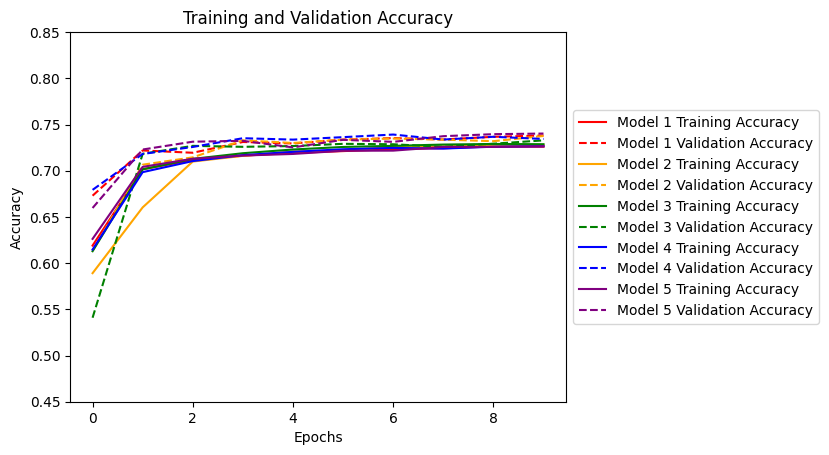

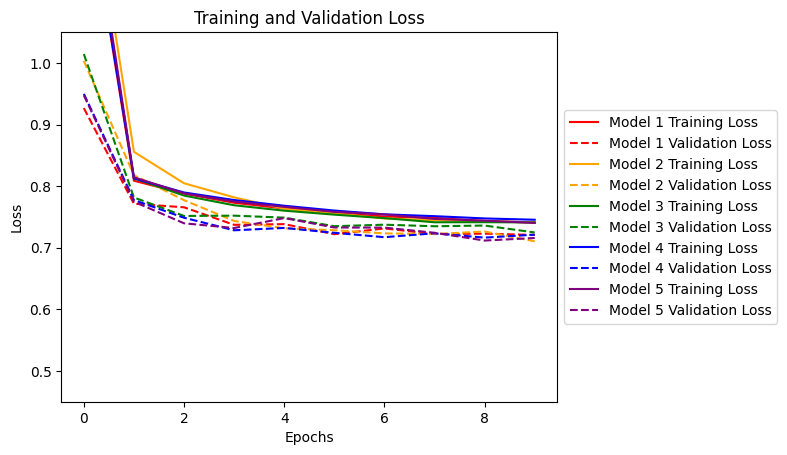

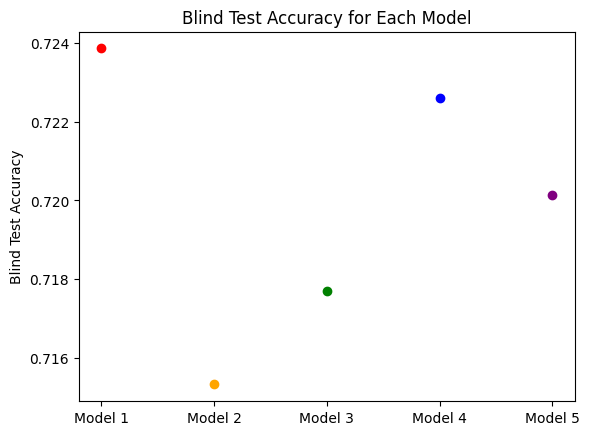

Best performing model: Model 1 with accuracy on blind test set: 0.7238637804985046


In [39]:
# evaluate model_reg
model_reg_w17_acc_blind, model_reg_w17_submodels = master_model_evaluater(get_model_reg, window=17)

Starting training of model 1
Epoch 1/10
308/308 [==============================] - 4s 7ms/step - loss: 0.8070 - accuracy: 0.6556 - val_loss: 0.7461 - val_accuracy: 0.6940
Epoch 2/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7366 - accuracy: 0.6994 - val_loss: 0.7184 - val_accuracy: 0.7078
Epoch 3/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7194 - accuracy: 0.7064 - val_loss: 0.7051 - val_accuracy: 0.7120
Epoch 4/10
308/308 [==============================] - 2s 5ms/step - loss: 0.7068 - accuracy: 0.7123 - val_loss: 0.6990 - val_accuracy: 0.7174
Epoch 5/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6917 - accuracy: 0.7198 - val_loss: 0.6812 - val_accuracy: 0.7245
Epoch 6/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6695 - accuracy: 0.7301 - val_loss: 0.6628 - val_accuracy: 0.7313
Epoch 7/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6484 - accuracy: 0.7386 - val_loss: 0.6421 

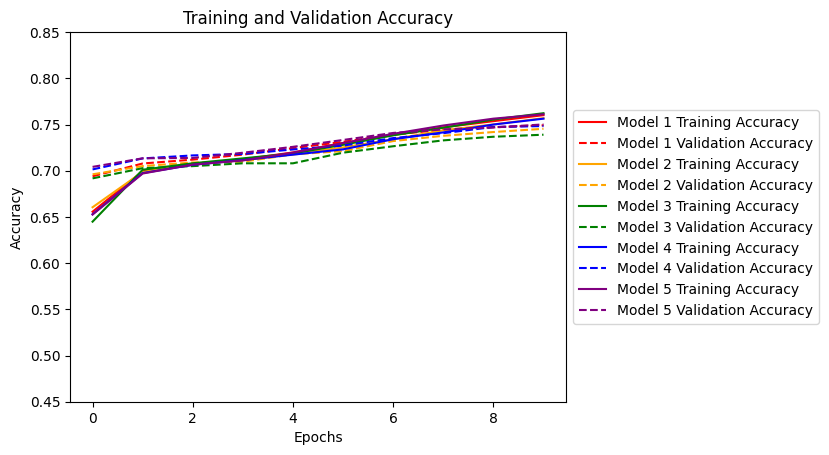

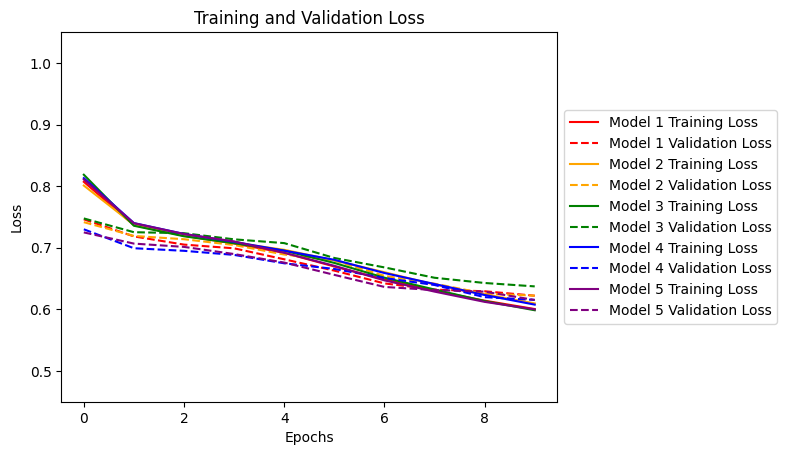

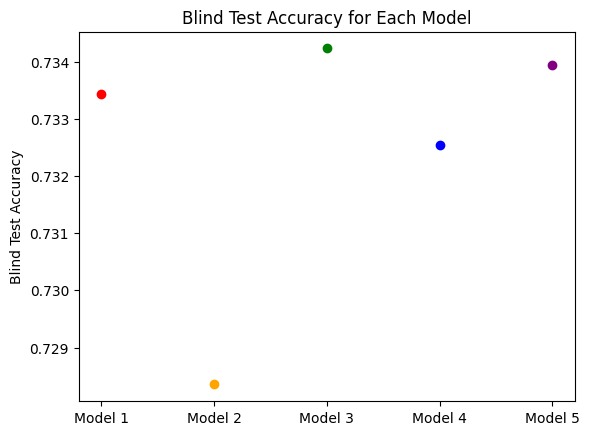

Best performing model: Model 3 with accuracy on blind test set: 0.7342281341552734


In [40]:
# evaluate model_tanh
model_tanh_w17_acc_blind, model_tanh_w17_submodels = master_model_evaluater(get_model_tanh, window=17)

Starting training of model 1
Epoch 1/10
308/308 [==============================] - 5s 8ms/step - loss: 0.8358 - accuracy: 0.6270 - val_loss: 0.7558 - val_accuracy: 0.7062
Epoch 2/10
308/308 [==============================] - 2s 7ms/step - loss: 0.7156 - accuracy: 0.7077 - val_loss: 0.6747 - val_accuracy: 0.7225
Epoch 3/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6627 - accuracy: 0.7265 - val_loss: 0.6326 - val_accuracy: 0.7387
Epoch 4/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6321 - accuracy: 0.7395 - val_loss: 0.6201 - val_accuracy: 0.7447
Epoch 5/10
308/308 [==============================] - 2s 6ms/step - loss: 0.6106 - accuracy: 0.7487 - val_loss: 0.6027 - val_accuracy: 0.7524
Epoch 6/10
308/308 [==============================] - 2s 6ms/step - loss: 0.5963 - accuracy: 0.7529 - val_loss: 0.6047 - val_accuracy: 0.7525
Epoch 7/10
308/308 [==============================] - 2s 6ms/step - loss: 0.5814 - accuracy: 0.7603 - val_loss: 0.5990 

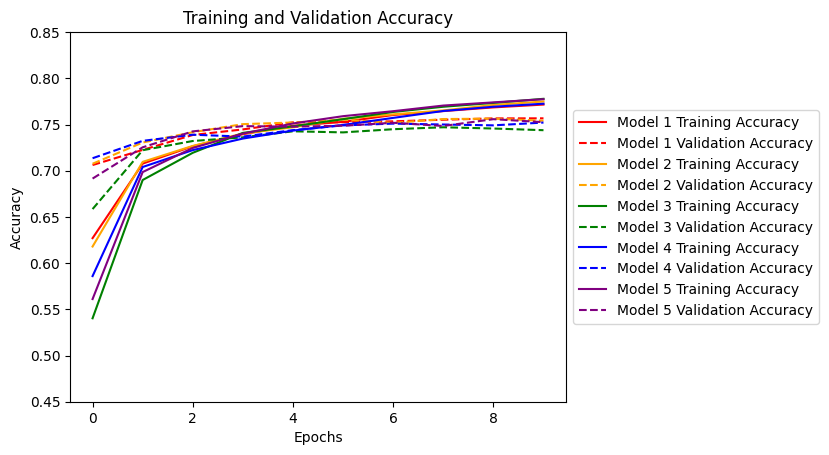

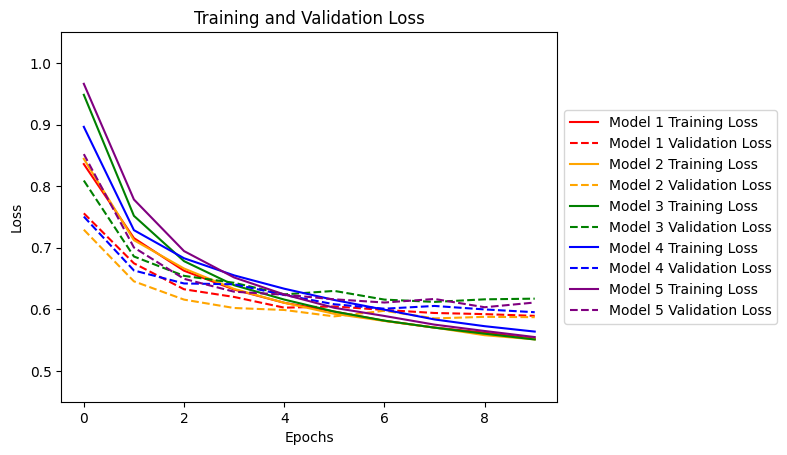

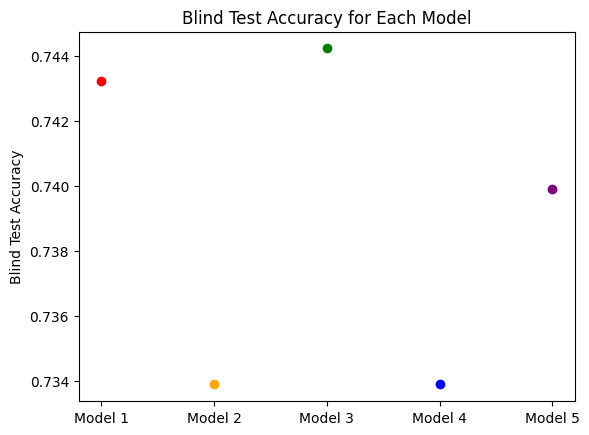

Best performing model: Model 3 with accuracy on blind test set: 0.7442384362220764


In [41]:
# evaluate model_extra_layers (here: highest scoring model is submodel 3)
model_extra_layers_w17_acc_blind, model_extra_layers_w17_submodels = master_model_evaluater(get_model_extra_layers, window=17)

Starting training of model 1
Epoch 1/10
308/308 [==============================] - 3s 6ms/step - loss: 0.8083 - accuracy: 0.6482 - val_loss: 0.7344 - val_accuracy: 0.7015
Epoch 2/10
308/308 [==============================] - 2s 5ms/step - loss: 0.6979 - accuracy: 0.7099 - val_loss: 0.6675 - val_accuracy: 0.7228
Epoch 3/10
308/308 [==============================] - 1s 5ms/step - loss: 0.6573 - accuracy: 0.7276 - val_loss: 0.6371 - val_accuracy: 0.7372
Epoch 4/10
308/308 [==============================] - 1s 5ms/step - loss: 0.6292 - accuracy: 0.7394 - val_loss: 0.6190 - val_accuracy: 0.7426
Epoch 5/10
308/308 [==============================] - 1s 5ms/step - loss: 0.6103 - accuracy: 0.7487 - val_loss: 0.6083 - val_accuracy: 0.7491
Epoch 6/10
308/308 [==============================] - 1s 5ms/step - loss: 0.5945 - accuracy: 0.7556 - val_loss: 0.6012 - val_accuracy: 0.7509
Epoch 7/10
308/308 [==============================] - 1s 5ms/step - loss: 0.5817 - accuracy: 0.7597 - val_loss: 0.5951 

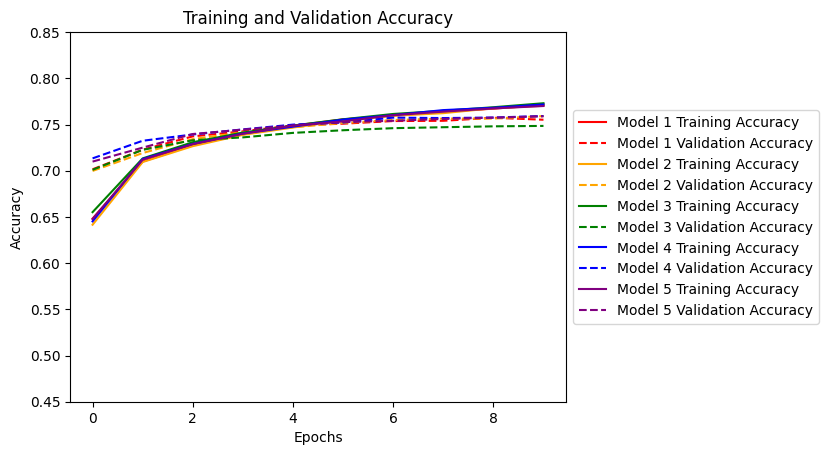

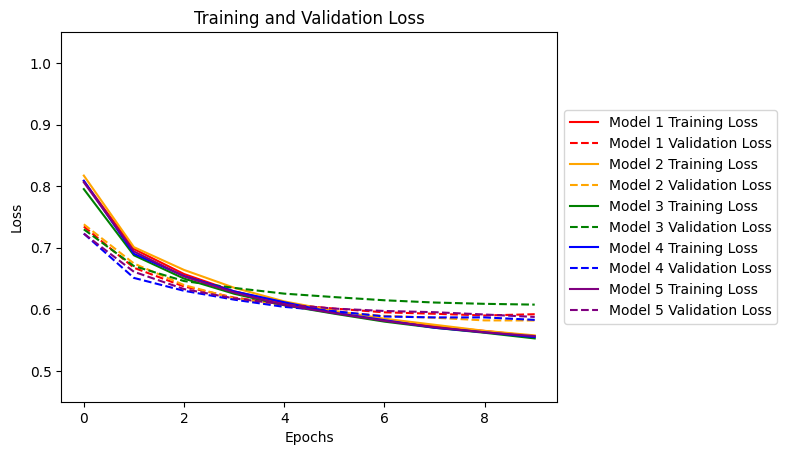

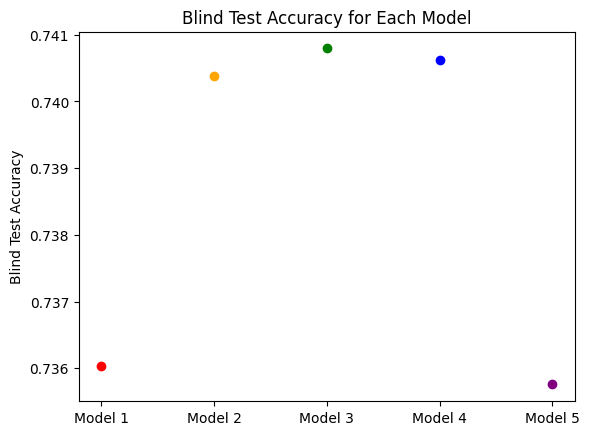

Best performing model: Model 3 with accuracy on blind test set: 0.7407943606376648


In [42]:
# evaluate model_less_layers
model_less_layers_w17_acc_blind, model_less_layers_w17_submodels = master_model_evaluater(get_model_less_layers, window=17)

# 10. Secondary Structure Predictor

The secondary stucture predictor is based on the highest-scoring model from previously:
model_extra_layers_w17

*   model_extra_layers_w17

For reasons of reproducibility, the model (incl. weights) are accessed from the git hub clone

Note: sections 1-3 of this notebook need to be run first


Additionally required functions for the main structure predictor:

In [19]:
def predict_with_saved_model(input_data):
    """Get prediciton from input data using a presaved model

    Parameters:
    input_data (numpy array): joint sequence with profile derived from PSSM
                              dimensions: (input_length, 17, 40)

    Returns:
    predictions (numpy array): model predictions (coded as probabilities)
    """

    with open("/content/secondary_structure_prediction_project/" +
              "model_extra_layers_w17_submodel_3.json", "r") as json_file:
        model_architecture = json.load(json_file)

    loaded_model = model_from_json(model_architecture)

    with open("/content/secondary_structure_prediction_project/" +
              "model_extra_layers_w17_submodel_3_weights.pkl", "rb") as f:
        model_weights = pickle.load(f)

    loaded_model.set_weights(model_weights)

    predictions = loaded_model.predict(input_data)

    return predictions

def prediction_to_sequence(predictions):
    """Derive secondary structure from the predictionsas sequence

    Parameters:
    predictions (numpy array): model predictions (coded as probabilities)

    Returns:
    sequence (list of strings): predicted sec structure as list element
    """
    ss_map = {0: 'H', 1: 'E', 2: 'C'}
    sequence = [ss_map[np.argmax(pred)] for pred in predictions]
    return sequence

def seq_to_profile(seq):
    """Converts a protein sequence into a binary profile

    Parameters:
    seq (str): protein sequence

    Returns:
    profile (list): binary profile of input sequence
    """
    profile = []
    aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M',
               'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    for res in seq:
	    profile_line = []
	    for aa in aa_list:
		    if res == aa:
			    profile_line.append(1)
		    else:
			    profile_line.append(0)
	    profile.append(profile_line)
    return profile

def one_hot_encode_seq(sequence):
    """Applies one-hot-encoding to a protein sequence

    Parameters:
    sequence (str): protein sequence

    Returns:
    encoding (numpy array): one-hot encoded sequence
    profile (list): binary profile of input sequence
    """
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    num_aas = len(amino_acids)
    profile = seq_to_profile(sequence)

  # one-hot encode protein sequence
    encoding = np.zeros((len(sequence), num_aas))
    for i, aa in enumerate(sequence):
      if aa in amino_acids:
        index = amino_acids.index(aa)
        encoding[i, index] = 1
      else: encoding[i, :] = 0.05

    return encoding, profile

 Main Prediction Function

In [21]:
def predict_sec_structure(input):
    """Predicts secondary structures for each residue

    Parameters:
    input (str): PSSM file, FASTA file or single sequence

    Returns:
    concatenated_predicted_sequence (str): predicted secondary structure
    """

    window = 17
    X = []

    # format according to input type (pssm, fasta or direct input)

    if input[-5:] == ".pssm": #check if pssm file
        sequence, profile = np.array(parse_pssm(input))
    else:
        if input[-6:] == ".fasta": #check if fastafile
            input = parse_fasta(input) # for silgle sequences
        sequence, profile = np.array(one_hot_encode_seq(input))
    x = np.concatenate((sequence, profile), axis=-1)

    #add (window-1)/2 padding on both sequence sides
    #to create window for first and last positions
    side = int((window-1)/2)
    x_pad = np.zeros((side, 40))
    x = np.concatenate((x_pad, x, x_pad), axis=0)
    #extract all windows
    X += [x[i-side:i+side+1,:] for i in range(side, len(x)-side-1)]
    X.append(x[-2*side-1:,:])


    #predict the secondary structure
    predictions = predict_with_saved_model(np.array(X))
    predicted_sequence_X = prediction_to_sequence(predictions)
    concatenated_predicted_sequence = ''.join(predicted_sequence_X)

    return concatenated_predicted_sequence


Example usage and printing quality metrics

In [15]:
# Example - predicting  4S1H:A from single sequence and from pssm file
single_sequence_test = ("MTNKVLTISSYVCSGFVGNRCGMIILDSFQIQSIFVLTTHLANHTGYPVVGGSG"
                        "VLLNDFISIMDSLEVNHLDKDIEFLVTGYFPSSDLVYETINRVKRIKDNKKVYF"
                        "LCDPILGDNGKMYTKSEVQDSMKELIKYADIITPNATELSFLTGLEVNSVSEAI"
                        "KACHILHEQGIPVILVTSIKEGNDIILLCSFKDTLNNKNFTIKIPRIEGDFTGV"
                        "GDTLTYILLSWIIKGIPLEHAVNRAISTLQTILRNTVGTAEINIINCIPYLKGT"
                        "EESFTITYILEHHHHHH")

input_pssmfile_test = '/content/protein-ss-pred/data/blindTest/pssm/4S1H:A.pssm'

In [25]:
# store predictions from the different sources (direct input, fasta or pssmfile)
prediction_from_single_seq = predict_sec_structure(single_sequence_test)
fastafilepath = ('/content/secondary_structure_prediction_project/'
                 '4s1h_entry.fasta')
prediction_from_fastafile = predict_sec_structure(fastafilepath)

prediction_from_pssmfile = predict_sec_structure(input_pssmfile_test)

9/9 [==============================] - 0s 2ms/step


In [26]:
# validate that the manual sequence input equals the one from the  fasta file
prediction_from_single_seq == prediction_from_fastafile

True

In [204]:
# get true three-state model for comparison
dssp_file_test = '/content/protein-ss-pred/data/blindTest/dssp/4S1H:A.dssp'
dssp_true = parse_dssp(dssp_file_test)

print(dssp_true)

CCCCEEEEECCECCCCCHHHHHHHHHHHCCCCEEEEECEEECCCCCCCCCCEEECCHHHHHHHHHHHHHCCCCCCCCEEEECCCCCHHHHHHHHHHHHHHCCCCCCEEEECCCCEECCEECCCHHHHHHHHHHHHHCCEECCCHHHHHHHHCCCCCCHHHHHHHHHHHHHCCCCEEEEEEEEECCEEEEEEEECCCCCCCCEEEEEECCCCCCCCHHHHHHHHHHHHHHCCCCHHHHHHHHHHHHHHHHHCCCCCCCCCCCCCHHHCCCCCCCCCCEECCCCHHHCC


In [154]:
#define function to print the quality metrics

def print_quality_metrics(dssp_true, dssp_predicted):
    """Prints accuracy, F1 score and MCC score for prediction

    Parameters:
    dssp_true (str): true secondary structure prediction
    dssp_predicted (str): predicted secondary structure prediction
    """

    dssp_true = [char for char in list(dssp_true)]
    dssp_predicted = [char for char in list(dssp_predicted)]

    accuracy = accuracy_score(dssp_true, dssp_predicted)

    f1_weighted = f1_score(dssp_true, dssp_predicted, average='weighted')

    mcc = matthews_corrcoef(dssp_true, dssp_predicted)

    # Print the results
    print('Accuracy:', round(accuracy, 5))
    print('F1 score (weighted average):', round(f1_weighted, 5))
    print('MCC:', round(mcc, 5))

In [157]:
# quality metric for single sequence prediction
print_quality_metrics(dssp_true, prediction_from_single_seq)

Accuracy: 0.66202
F1 score (weighted average): 0.67129
MCC: 0.49271


In [156]:
# quality metric for prediction from pssm input
print_quality_metrics(dssp_true, prediction_from_pssmfile)

Accuracy: 0.77352
F1 score (weighted average): 0.77168
MCC: 0.646
